In [2]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
from scipy.stats import pearsonr
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

## Importing CSVs and Slicing the correct experimental time

In [3]:
# Get a list of all inbound and outbound traffic CSV files
experiment_files = glob.glob('experiments_*.csv')


# Read and concatenate all inbound and outbound traffic CSV files
experiment_data = pd.concat((pd.read_csv(f) for f in experiment_files))

# Drop duplicates
experiment_data = experiment_data.drop_duplicates(subset='Experiment Start')

# Extract relevant columns
experiment_data = experiment_data[['chaosresult_name', 'Experiment Start', 'Chaos Injected', 'Experiment End']]

# Convert timestamps to datetime and rename columns
experiment_data['Experiment Start'] = pd.to_datetime(experiment_data['Experiment Start'], unit='ms')
experiment_data['Chaos Injected'] = pd.to_datetime(experiment_data['Chaos Injected'], unit='ms')
experiment_data['Experiment End'] = pd.to_datetime(experiment_data['Experiment End'], unit='ms')
experiment_data.rename(columns={'Experiment Start': 'start_time', 'Chaos Injected': 'inject_change', 'Experiment End': 'end_time'}, inplace=True)

# Adding two hours to all timestamps in experiments DataFrame because of time zone difference
experiment_data['start_time'] = experiment_data['start_time'] + pd.Timedelta(hours=2)
experiment_data['inject_change'] = experiment_data['inject_change'] + pd.Timedelta(hours=2)
experiment_data['end_time'] = experiment_data['end_time'] + pd.Timedelta(hours=2)


# Convert your cutoff time to a datetime object
cutoff_time = pd.to_datetime('2023-07-15 18:05:27')

# Filter the experiments DataFrame
experiment_data = experiment_data[experiment_data['start_time'] > cutoff_time]

print(experiment_data.head())



                   chaosresult_name          start_time       inject_change  \
0  pod-cpu-hog-1lybh4rx-pod-cpu-hog 2023-07-16 12:20:28 2023-07-16 12:22:43   
1  pod-cpu-hog-1lyfsbkd-pod-cpu-hog 2023-07-15 23:22:22 2023-07-15 23:24:37   
2  pod-cpu-hog-39bc9kkf-pod-cpu-hog 2023-07-16 12:26:39 2023-07-16 12:28:54   
3  pod-cpu-hog-39bpcttl-pod-cpu-hog 2023-07-15 23:28:34 2023-07-15 23:30:50   
4  pod-cpu-hog-4z649dhv-pod-cpu-hog 2023-07-15 23:34:46 2023-07-15 23:37:01   

             end_time  
0 2023-07-16 12:25:58  
1 2023-07-15 23:27:52  
2 2023-07-16 12:32:10  
3 2023-07-15 23:34:04  
4 2023-07-15 23:40:16  


### Importing the non-litmus experiments

In [4]:

# Get a list of all the files matching the pattern "perform_update_X.txt"
file_list = glob.glob("perform_update_*.txt")

experiment = []

# Iterate over the file list
for file_name in file_list:
    # Read the file and extract the relevant information
    with open(file_name, "r") as file:
        # Read the lines from the file
        lines = file.readlines()

        start_time = None
        inject_change = None
        end_time = None

        for line in lines:
            line = line.strip()

            if line.startswith('Start Trial'):
                start_time = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', line).group()
                trial_number = int(re.search(r'Start Trial (\d+)', line).group(1))
            elif line.startswith('Update pushed'):
                inject_change = re.search(r'Update pushed: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)

            elif line.startswith('Trial'):
                end_time = re.search(r'Trial \d+ over (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)
                # Create a dictionary representing the trial information
                trial_data = {
                    'chaosresult_name': f'{file_name.split(".")[0]}_Trial{trial_number}',
                    'start_time': pd.to_datetime(start_time),
                    'inject_change': pd.to_datetime(inject_change),
                    'end_time': pd.to_datetime(end_time)
                }
                # Append the trial data to the list
                experiment.append(trial_data)

# Create a DataFrame from the extracted trial data
update_experiments = pd.DataFrame(experiment)

update_experiments.style


# Concatenate the new data with the existing experiment_data DataFrame
experiment_data = pd.concat([experiment_data, update_experiments], ignore_index=True)

In [5]:
# Get a list of all the files matching the pattern "perform_update_X.txt"
file_list = glob.glob("increase_load_*.txt")

experiment = []

# Iterate over the file list
for file_name in file_list:
    # Read the file and extract the relevant information
    with open(file_name, "r") as file:
        # Read the lines from the file
        lines = file.readlines()

        start_time = None
        inject_change = None
        end_time = None

        for line in lines:
            line = line.strip()

            if line.startswith('-------------Start Trial'):
                start_time = re.search(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', line).group()
                trial_number = int(re.search(r'-------------Start Trial (\d+)', line).group(1))
            elif line.startswith('-------------Chaos injected'):
                inject_change = re.search(r'-------------Chaos injected: (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)

            elif line.startswith('-------------Trial'):
                end_time = re.search(r'-------------Trial \d+ over (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})', line).group(1)
                # Create a dictionary representing the trial information
                trial_data = {
                    'chaosresult_name': f'{file_name.split(".")[0]}_Trial{trial_number}',
                    'start_time': pd.to_datetime(start_time),
                    'inject_change': pd.to_datetime(inject_change),
                    'end_time': pd.to_datetime(end_time)
                }
                # Append the trial data to the list
                experiment.append(trial_data)

# Create a DataFrame from the extracted trial data
update_experiments = pd.DataFrame(experiment)

update_experiments.style


# Concatenate the new data with the existing experiment_data DataFrame
experiment_data = pd.concat([experiment_data, update_experiments], ignore_index=True)

In [6]:
# Get the start time of the first experiment
first_start_time = experiment_data['start_time'].min()
print(f"The start time of the first experiment is: {first_start_time}")

# Get the end time of the last experiment
last_end_time = experiment_data['end_time'].max()
print(f"The end time of the last experiment is: {last_end_time}")

experiment_data[experiment_data['end_time']==experiment_data['end_time'].max()]

The start time of the first experiment is: 2023-07-15 18:05:27
The end time of the last experiment is: 2023-07-19 14:48:03


,chaosresult_name,start_time,inject_change,end_time
439,pod-cpu-hog-du78zt9b-pod-cpu-hog,2023-07-19 14:42:32,2023-07-19 14:44:47,2023-07-19 14:48:03


## Prepare the experiments

In [7]:
# Define a function to extract the type from the chaosresult_name
def get_type(name):
    if 'cpu' in name:
        return 'cpu'
    elif 'memory' in name:
        return 'memory'
    elif 'network' in name:
        return 'network'
    elif 'delete' in name:
        return 'delete'
    elif 'update' in name:
        return 'update'
    elif 'load' in name:
        return 'load'
    else:
        return 'unknown'

# Apply this function to the chaosresult_name column to create a new type column
experiment_data['type'] = experiment_data['chaosresult_name'].apply(get_type)

# Sort by start_time
experiment_data = experiment_data.sort_values(by='start_time')

#drop failed experiment
rows_to_drop = [277, 285, 309]
experiment_data.drop(rows_to_drop, inplace=True)

# Create a new 'group' column
experiment_data['group'] = experiment_data.groupby('type').cumcount() // 10

print(experiment_data.head())


            chaosresult_name          start_time       inject_change  \
493  perform_update_1_Trial1 2023-07-15 18:05:27 2023-07-15 18:06:00   
494  perform_update_1_Trial2 2023-07-15 18:08:30 2023-07-15 18:09:03   
495  perform_update_1_Trial3 2023-07-15 18:11:33 2023-07-15 18:12:06   
496  perform_update_1_Trial4 2023-07-15 18:14:36 2023-07-15 18:15:08   
497  perform_update_1_Trial5 2023-07-15 18:17:38 2023-07-15 18:18:11   

               end_time    type  group  
493 2023-07-15 18:08:30  update      0  
494 2023-07-15 18:11:33  update      0  
495 2023-07-15 18:14:36  update      0  
496 2023-07-15 18:17:38  update      0  
497 2023-07-15 18:20:41  update      0  


In [8]:
#experiment_data.style

In [9]:
# Check the number of trials in each group for each type
trial_counts = experiment_data.groupby(['type', 'group']).size()

# Print the counts
print(trial_counts)


type     group
cpu      0        10
         1        10
         2        10
         3        10
         4        10
         5        10
         6        10
         7        10
         8        10
         9        10
         10       10
         11       10
         12       10
         13       10
         14       10
         15       10
         16       10
         17       10
         18       10
         19       10
         20       10
         21       10
         22       10
         23       10
         24       10
         25       10
         26       10
         27       10
         28       10
         29       10
         30       10
         31       10
         32       10
         33       10
         34       10
         35       10
         36       10
         37       10
         38       10
delete   0        10
         1        10
         2        10
load     0        10
         1        10
memory   0        10
         1        10
         2        1

In [10]:
# Group by type and group, and get the count of trials and the start time of the first trial
group_info = experiment_data.groupby(['type', 'group']).agg(
    trial_count=pd.NamedAgg(column='chaosresult_name', aggfunc='size'),
    first_trial_start=pd.NamedAgg(column='start_time', aggfunc='min')
)

# Filter groups that do not have exactly 10 trials
incomplete_groups = group_info[group_info['trial_count'] != 10]

# Print the start time of the first trial for these groups
print(incomplete_groups['first_trial_start'])


Series([], Name: first_trial_start, dtype: datetime64[ns])


## Importing the request data from grafana

In [11]:
# Get a list of all inbound and outbound traffic CSV files
inbound_files = glob.glob('inbound_traffic_*.csv')
outbound_files = glob.glob('outbound_traffic_*.csv')

# Read and concatenate all inbound and outbound traffic CSV files
inbound_traffic = pd.concat((pd.read_csv(f, parse_dates=['Time']) for f in inbound_files))
outbound_traffic = pd.concat((pd.read_csv(f, parse_dates=['Time']) for f in outbound_files))

# Drop duplicates
inbound_traffic = inbound_traffic.drop_duplicates(subset='Time')
outbound_traffic = outbound_traffic.drop_duplicates(subset='Time')

# Rename Column Name
outbound_traffic = outbound_traffic.rename(columns={"Response Within Response Time": "SRinT/SR"})
inbound_traffic = inbound_traffic.rename(columns={"Response Within Response Time": "SRinT/SR"})


# Convert the 'Response Within Response Time' columns to ratios
outbound_traffic['SRinT/SR'] = outbound_traffic['SRinT/SR'].str.rstrip('%').astype('float') / 100.0
inbound_traffic['SRinT/SR'] = inbound_traffic['SRinT/SR'].str.rstrip('%').astype('float') / 100.0


In [12]:
outbound_traffic.describe()

,Time,SRinT/SR
count,33611,33611.000000
mean,2023-07-17 16:25:48.682574336,0.971641
min,2023-07-15 16:50:00,0.611000
25%,2023-07-16 16:12:15,0.959000
50%,2023-07-17 17:01:20,1.000000
75%,2023-07-18 16:23:35,1.000000
max,2023-07-19 15:44:00,1.030000
std,NaN,0.044688


In [13]:
outbound_traffic[outbound_traffic.duplicated()]

,Time,SRinT/SR


In [14]:
inbound_traffic[inbound_traffic.duplicated(['Time'])]

,Time,SRinT/SR


In [15]:
inbound_traffic.describe()

,Time,SRinT/SR
count,33325,33325.000000
mean,2023-07-17 15:57:19.609302016,0.974823
min,2023-07-15 16:50:00,0.795000
25%,2023-07-16 15:58:30,0.959000
50%,2023-07-17 16:32:20,0.984000
75%,2023-07-18 15:40:50,1.000000
max,2023-07-19 14:49:20,1.010000
std,NaN,0.027609


In [16]:
def calculate_timestamp(start_time, end_time, next_time, data, condition):
    subset = data[(data['Time'] >= start_time) & (data['Time'] <= end_time) & condition]
    if not subset.empty:
        index = subset['Time'].idxmin()
        return subset.loc[index, 'Time']
    return pd.NaT

def calculate_fail_timestamps(row):
    # Calculate 'fail_init'
    outbound_subset = outbound_traffic[(outbound_traffic['Time'] >= row['inject_change']) & (outbound_traffic['Time'] <= row['end_time']) & (outbound_traffic['SRinT/SR'] < 0.95)]
    outbound_subset.reset_index(drop=True, inplace=True)
    fail_init = calculate_timestamp(row['inject_change'], row['end_time'], pd.NaT, outbound_subset, True)

    # Calculate 'fail_end'
    # next_trial_inject_change = experiment_data.loc[row.name + 1, 'inject_change'] if row.name < len(experiment_data) - 1 else pd.NaT
    if row.name == len(experiment_data) - 1:
        next_trial_inject_change = row['inject_change'] + pd.Timedelta(minutes=10)
    else:
        next_trial_inject_change = experiment_data.loc[row.name + 1, 'end_time']
    
    if pd.isna(fail_init):
        fail_end = pd.NaT
    else:
        outbound_subset = outbound_traffic[(outbound_traffic['Time'] >= fail_init) & (outbound_traffic['Time'] <= next_trial_inject_change) & (outbound_traffic['SRinT/SR'] > 0.95)]
        outbound_subset.reset_index(drop=True, inplace=True)
        fail_end = calculate_timestamp(fail_init, next_trial_inject_change, row['end_time'], outbound_subset, True)

    # Calculate 'fail_detect'
    if pd.isna(row['inject_change']):
        fail_detect = pd.NaT
    else:
        inbound_subset = inbound_traffic[(inbound_traffic['Time'] >= (row['inject_change'] + pd.Timedelta(seconds=20))) & (inbound_traffic['Time'] <= row['end_time']) & (inbound_traffic['SRinT/SR'] < 0.95)]
        inbound_subset.reset_index(drop=True, inplace=True)
        fail_detect = calculate_timestamp(row['inject_change'] + pd.Timedelta(seconds=20), row['end_time'], pd.NaT, inbound_subset, True)

    if pd.isna(fail_init) and not pd.isna(fail_detect):
        print(f"Warning: False positive failure detection at {fail_detect} for trial {row.name}. Setting fail_detect to NA.")
        fail_detect = pd.NaT
        
    return pd.Series([fail_init, fail_end, fail_detect])



In [17]:
# Reset the index of the experiment_data DataFrame
experiment_data.reset_index(drop=True, inplace=True)

experiment_data[['fail_init', 'fail_end', 'fail_detect']] = experiment_data.apply(calculate_fail_timestamps, axis=1)


In [18]:
experiment_data.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect
count,530,530,530,530.000000,400,399,245
mean,2023-07-17 18:43:13.760377344,2023-07-17 18:45:32.652830208,2023-07-17 18:48:48.911320832,14.245283,2023-07-18 01:39:58.525000192,2023-07-18 01:50:30.275688960,2023-07-18 07:09:49.387755008
min,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40
25%,2023-07-16 16:12:21.500000,2023-07-16 16:12:53.750000128,2023-07-16 16:15:23.750000128,2.000000,2023-07-17 09:44:30,2023-07-17 09:54:35,2023-07-17 16:38:40
50%,2023-07-17 20:11:41,2023-07-17 20:13:56.500000,2023-07-17 20:17:11.500000,12.000000,2023-07-18 02:46:55,2023-07-18 02:51:00,2023-07-18 08:39:10
75%,2023-07-18 22:25:37,2023-07-18 22:27:52,2023-07-18 22:31:07.750000128,25.000000,2023-07-19 02:05:07.500000,2023-07-19 02:22:20,2023-07-19 04:45:00
max,2023-07-19 14:42:32,2023-07-19 14:44:47,2023-07-19 14:48:03,38.000000,2023-07-19 14:45:00,2023-07-19 14:45:40,2023-07-19 14:46:00
std,NaN,NaN,NaN,12.518275,NaN,NaN,NaN


In [19]:
#experiment_data.style

In [20]:
# Filter trials where fail_end is after end_time
failed_trials = experiment_data[experiment_data['fail_detect'] < experiment_data['fail_init']]

# Print the failed trials
failed_trials.describe()


# set the detection to the same time as fail_init to avoid negative values
experiment_data.loc[experiment_data['fail_detect'] < experiment_data['fail_init'], 'fail_detect'] = experiment_data['fail_init']

# Print the failed trials
failed_trials.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect
count,52,52,52,52.000000,52,52,52
mean,2023-07-18 07:19:15.576922624,2023-07-18 07:21:27.807692800,2023-07-18 07:24:44.807692288,21.230769,2023-07-18 07:22:41.538461696,2023-07-18 07:25:10.384615424,2023-07-18 07:21:56.923077120
min,2023-07-15 23:09:57,2023-07-15 23:12:12,2023-07-15 23:15:27,0.000000,2023-07-15 23:14:20,2023-07-15 23:16:30,2023-07-15 23:12:40
25%,2023-07-17 21:27:54.750000128,2023-07-17 21:30:09.750000128,2023-07-17 21:33:25.750000128,14.750000,2023-07-17 21:31:47.500000,2023-07-17 21:32:35,2023-07-17 21:30:35
50%,2023-07-18 09:23:38,2023-07-18 09:25:53,2023-07-18 09:29:08.500000,24.000000,2023-07-18 09:26:40,2023-07-18 09:30:05,2023-07-18 09:26:15
75%,2023-07-19 05:40:38.750000128,2023-07-19 05:42:53.750000128,2023-07-19 05:46:08,31.000000,2023-07-19 05:43:47.500000,2023-07-19 05:45:32.500000,2023-07-19 05:43:22.500000
max,2023-07-19 12:49:58,2023-07-19 12:52:13,2023-07-19 12:55:28,37.000000,2023-07-19 12:54:00,2023-07-19 12:54:40,2023-07-19 12:52:50
std,NaN,NaN,NaN,12.464248,NaN,NaN,NaN


In [21]:
# Filter trials where fail_end is NaT
failed_trials = experiment_data[pd.isna(experiment_data['fail_end'])]

# Print the failed trials
failed_trials.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect
0,perform_update_1_Trial1,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,update,0,NaT,NaT,NaT
1,perform_update_1_Trial2,2023-07-15 18:08:30,2023-07-15 18:09:03,2023-07-15 18:11:33,update,0,NaT,NaT,NaT
2,perform_update_1_Trial3,2023-07-15 18:11:33,2023-07-15 18:12:06,2023-07-15 18:14:36,update,0,NaT,NaT,NaT
3,perform_update_1_Trial4,2023-07-15 18:14:36,2023-07-15 18:15:08,2023-07-15 18:17:38,update,0,NaT,NaT,NaT
4,perform_update_1_Trial5,2023-07-15 18:17:38,2023-07-15 18:18:11,2023-07-15 18:20:41,update,0,NaT,NaT,NaT
5,perform_update_1_Trial6,2023-07-15 18:20:41,2023-07-15 18:21:14,2023-07-15 18:23:44,update,0,NaT,NaT,NaT
6,perform_update_1_Trial7,2023-07-15 18:23:44,2023-07-15 18:24:17,2023-07-15 18:26:47,update,0,NaT,NaT,NaT
7,perform_update_1_Trial8,2023-07-15 18:26:47,2023-07-15 18:27:19,2023-07-15 18:29:49,update,0,NaT,NaT,NaT
8,perform_update_1_Trial9,2023-07-15 18:29:49,2023-07-15 18:30:22,2023-07-15 18:32:52,update,0,NaT,NaT,NaT
9,perform_update_1_Trial10,2023-07-15 18:32:52,2023-07-15 18:33:24,2023-07-15 18:35:54,update,0,NaT,NaT,NaT


In [22]:
# Filter trials where fail_end is NaT but fail_init is not NaT
failed_trials = experiment_data[pd.isna(experiment_data['fail_end']) & ~pd.isna(experiment_data['fail_init'])]

# Print the failed trials
failed_trials.head()


,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect
14,increase_load_1_Trial5,2023-07-15 19:10:14,2023-07-15 19:11:14,2023-07-15 19:15:14,load,0,2023-07-15 19:12:30,NaT,2023-07-15 19:12:30


In [23]:
# set fail_end to the next rows fail_end
# Get the indices where the condition is satisfied
indices = experiment_data[pd.isna(experiment_data['fail_end']) & ~pd.isna(experiment_data['fail_init'])].index

# Update the 'fail_end' value using .loc
experiment_data.loc[indices, 'fail_end'] = experiment_data.loc[indices + 1, 'fail_end'].values

# Filter trials where fail_end is NaT but fail_init is not NaT
failed_trials = experiment_data[pd.isna(experiment_data['fail_end']) & ~pd.isna(experiment_data['fail_init'])]

failed_trials.head()

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect


In [24]:
failed_trials.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect


In [25]:
print(experiment_data)

                     chaosresult_name          start_time       inject_change  \
0             perform_update_1_Trial1 2023-07-15 18:05:27 2023-07-15 18:06:00   
1             perform_update_1_Trial2 2023-07-15 18:08:30 2023-07-15 18:09:03   
2             perform_update_1_Trial3 2023-07-15 18:11:33 2023-07-15 18:12:06   
3             perform_update_1_Trial4 2023-07-15 18:14:36 2023-07-15 18:15:08   
4             perform_update_1_Trial5 2023-07-15 18:17:38 2023-07-15 18:18:11   
..                                ...                 ...                 ...   
525  pod-cpu-hog-4z6c9swl-pod-cpu-hog 2023-07-19 14:17:43 2023-07-19 14:19:58   
526  pod-cpu-hog-7oylkdsg-pod-cpu-hog 2023-07-19 14:23:55 2023-07-19 14:26:11   
527  pod-cpu-hog-9o7snh8s-pod-cpu-hog 2023-07-19 14:30:07 2023-07-19 14:32:23   
528  pod-cpu-hog-bqu8t2ks-pod-cpu-hog 2023-07-19 14:36:20 2023-07-19 14:38:35   
529  pod-cpu-hog-du78zt9b-pod-cpu-hog 2023-07-19 14:42:32 2023-07-19 14:44:47   

               end_time    

## Calculate the Metrics

In [26]:
# Concatenate all login request csv files
all_login_files = glob.glob('login_requests_*.csv')
login_df_list = []

for filename in all_login_files:
    df = pd.read_csv(filename, parse_dates=['Time'])
    login_df_list.append(df)

login_df = pd.concat(login_df_list, axis=0, ignore_index=True)

login_df = login_df.drop_duplicates(subset='Time')

# Concatenate all slo csv files
all_slo_files = glob.glob('slo_*.csv')
slo_df_list = []

for filename in all_slo_files:
    df = pd.read_csv(filename, parse_dates=['Time'])
    slo_df_list.append(df)

    
print(slo_df_list)
slo_df = pd.concat(slo_df_list, axis=0, ignore_index=True)

slo_df = slo_df.drop_duplicates(subset='Time')


[                   Time GET /login 20ms GET /signup 20ms POST /logout 20ms  \
0   2023-07-15 16:50:00            100%             100%              100%   
1   2023-07-15 16:50:10            100%             100%              100%   
2   2023-07-15 16:50:20            100%             100%              100%   
3   2023-07-15 16:50:30            100%             100%               NaN   
4   2023-07-15 16:50:40             NaN             100%              100%   
..                  ...             ...              ...               ...   
704 2023-07-15 18:49:20            100%             100%              100%   
705 2023-07-15 18:49:30            100%             100%               NaN   
706 2023-07-15 18:49:40            100%             100%              100%   
707 2023-07-15 18:49:50            100%             100%               NaN   
708 2023-07-15 18:50:00            100%             100%              100%   

    GET / 30ms GET /home 30ms POST /deposit 300ms POST /paymen

In [27]:
print(login_df)

                     Time  POST /login (SRinT)  POST /login (SR)
0     2023-07-15 16:50:00                  0.5               0.5
1     2023-07-15 16:50:10                  0.6               0.6
2     2023-07-15 16:50:20                  0.7               0.7
3     2023-07-15 16:50:30                  0.8               0.8
4     2023-07-15 16:50:40                  0.9               0.9
...                   ...                  ...               ...
33676 2023-07-18 11:24:30                  0.6               0.6
33677 2023-07-18 11:24:40                  0.6               0.6
33678 2023-07-18 11:24:50                  0.7               0.7
33679 2023-07-18 11:25:00                  0.2               0.2
33680 2023-07-18 11:25:10                  0.7               0.7

[33619 rows x 3 columns]


In [28]:
# Convert percentage to float for all columns except "Time"
percentage_columns = slo_df.columns.drop("Time")
slo_df[percentage_columns] = slo_df[percentage_columns].replace({'%': ''}, regex=True).astype(float) / 100

In [29]:
print(login_df.isna().sum())

Time                    0
POST /login (SRinT)     0
POST /login (SR)       24
dtype: int64


In [30]:
login_df.dropna(inplace=True)

In [31]:
print(login_df.isna().sum())

Time                   0
POST /login (SRinT)    0
POST /login (SR)       0
dtype: int64


In [32]:
experiment_data[(experiment_data['inject_change'] == '2023-07-17 06:26:15')]

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect
176,pod-cpu-hog-7oyr7vgk-pod-cpu-hog,2023-07-17 06:24:00,2023-07-17 06:26:15,2023-07-17 06:29:30,cpu,5,2023-07-17 06:27:10,2023-07-17 06:30:50,2023-07-17 06:28:30


In [33]:
login_df[(login_df['Time']>"2023-07-17 06:26:15") & (login_df['Time']< "2023-07-17 06:29:30")]

,Time,POST /login (SRinT),POST /login (SR)
7964,2023-07-17 06:26:20,0.6,0.6
7965,2023-07-17 06:26:30,0.2,0.2
7966,2023-07-17 06:26:40,0.3,0.5
7967,2023-07-17 06:26:50,0.4,0.4
7968,2023-07-17 06:27:00,0.2,0.2
7969,2023-07-17 06:27:10,0.4,0.6
7970,2023-07-17 06:27:20,0.2,0.2
7971,2023-07-17 06:27:30,0.5,0.5
7972,2023-07-17 06:27:40,0.2,0.3
7973,2023-07-17 06:27:50,0.3,0.3


In [34]:
# Calculate antifragility scores
# Scalability
# Get r^2 of 'POST /login (SRinT)' and 'POST /login (SR)'
def scalability(row):
    mask = (login_df['Time'] >= row['inject_change']) & (login_df['Time'] <= row['end_time'])
    correlation = pearsonr(login_df.loc[mask, 'POST /login (SRinT)'], login_df.loc[mask, 'POST /login (SR)'])[0]
    return correlation**2 if not np.isnan(correlation) else np.nan

experiment_data['Scalability'] = experiment_data.apply(scalability, axis=1)



In [35]:
# Fault Tolerance
# Calculate mean ratio of 'POST /login (SRinT)' to 'POST /login (SR)'
def fault_tolerance(row):
    mask = (login_df['Time'] >= row['inject_change']) & (login_df['Time'] <= row['end_time'])
    total_requests = login_df.loc[mask, 'POST /login (SR)'].sum()
    requests_in_time = login_df.loc[mask, 'POST /login (SRinT)'].sum()
    return requests_in_time / total_requests if total_requests != 0 else np.nan

experiment_data['Fault Tolerance'] = experiment_data.apply(fault_tolerance, axis=1)




In [36]:
# Recoverability
# This is the "Time to Recovery," which is the difference between the "fail_end" and "fail_init" timestamps.
# If "fail_init" is null, indicating the system did not fail, the "Time to Recovery" is set as NA or null.
experiment_data['Recoverability'] = np.where(experiment_data['fail_init'].notna(), 
                                             (experiment_data['fail_end'] - experiment_data['fail_init']).dt.total_seconds(), 
                                             np.nan)

In [37]:
# Resistance
# This is the "Time to Failure," which is the difference between the "fail_init" and "Inject_Change" timestamps.
# If "fail_init" is null, this metric is set to a large value such as 1000, indicating the system did not fail.
experiment_data['Resistance'] = np.where(experiment_data['fail_init'].notna(), 
                                         (experiment_data['fail_init'] - experiment_data['inject_change']).dt.total_seconds(), 
                                         1000)

In [38]:
#Observability
#This is the "Time to Detect," which is the difference between the "fail_detect" and "fail_init" timestamps.
# If "fail_detect" is null, this metric is set to a large value such as 1000.
# If "fail_init" is null, indicating the system did not fail, the metric is set as NA or null.

def observability(row):
    if pd.isnull(row['fail_init']):
        return np.nan
    elif pd.isnull(row['fail_detect']):
        return 1000
    else:
        observability = (row['fail_detect'] - row['fail_init']).total_seconds()
        if observability < 0:
            return 0
        else:
            return observability

experiment_data['Observability'] = experiment_data.apply(observability, axis=1)


In [39]:
# Self-Organizing
# This is the proportion of time the system spent reconfiguring, relative to the total trial time.
# If "fail_end" or "fail_detect" is null, this metric is set to nan.
# If detection is after fail_end, use from fail_init to fail_end as the reconfiguration time
def self_organizing(row):
    if pd.isnull(row['fail_end']) or pd.isnull(row['fail_detect']):
        return np.nan
    elif row['fail_end'] < row['fail_detect']:
        reconfiguring_time = (row['fail_end'] - row['fail_init']).total_seconds()
        trial_time = (row['end_time'] - row['start_time']).total_seconds()
        return reconfiguring_time / trial_time if trial_time != 0 else np.nan
    else:
        reconfiguring_time = (row['fail_end'] - row['fail_detect']).total_seconds()
        trial_time = (row['end_time'] - row['start_time']).total_seconds()
        return reconfiguring_time / trial_time if trial_time != 0 else np.nan

experiment_data['Self-Organizing'] = experiment_data.apply(self_organizing, axis=1)


In [40]:
slo_df.head()

,Time,GET /login 20ms,GET /signup 20ms,POST /logout 20ms,GET / 30ms,GET /home 30ms,POST /deposit 300ms,POST /payment 300ms,POST /login 2000ms,POST /signup 3000ms
0,2023-07-15 16:50:00,1.0,1.0,1.0,1.000,1.000,1.0,1.0,1.0,1.0
1,2023-07-15 16:50:10,1.0,1.0,1.0,1.000,0.971,1.0,1.0,1.0,NaN
2,2023-07-15 16:50:20,1.0,1.0,1.0,1.000,1.000,1.0,1.0,1.0,1.0
3,2023-07-15 16:50:30,1.0,1.0,NaN,0.833,1.000,1.0,1.0,1.0,1.0
4,2023-07-15 16:50:40,NaN,1.0,1.0,1.000,1.000,1.0,1.0,1.0,NaN


In [41]:
# Blast Radius
def blast_radius(row):
    mask = (slo_df['Time'] >= row['inject_change']) & (slo_df['Time'] <= row['end_time'])
    avg_ratios = slo_df.loc[mask].drop(columns='Time').mean()
    return (avg_ratios < 0.95).sum()

experiment_data['Blast Radius'] = experiment_data.apply(blast_radius, axis=1)


In [42]:
test = experiment_data[experiment_data['Resistance']<1000]
test.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius
count,400,400,400,400.000000,400,400,245,400.000000,400.000000,400.000000,400.000000,400.000000,245.000000,400.00000
mean,2023-07-18 01:36:37.772499968,2023-07-18 01:38:50.497500160,2023-07-18 01:42:09.832500224,17.845000,2023-07-18 01:39:58.524999936,2023-07-18 01:42:19.824999936,2023-07-18 07:09:58.857142784,0.843153,0.906984,141.300000,68.027500,414.925000,0.409783,1.23750
min,2023-07-15 18:50:13,2023-07-15 18:51:13,2023-07-15 18:55:13,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40,0.263378,0.691489,10.000000,0.000000,0.000000,0.000000,0.00000
25%,2023-07-17 09:40:27,2023-07-17 09:42:42,2023-07-17 09:45:57,6.000000,2023-07-17 09:44:30,2023-07-17 09:46:47.500000,2023-07-17 16:38:40,0.798475,0.881129,100.000000,36.750000,10.000000,0.272727,1.00000
50%,2023-07-18 02:43:05.500000,2023-07-18 02:45:21,2023-07-18 02:48:36.500000,18.000000,2023-07-18 02:46:55,2023-07-18 02:48:30,2023-07-18 08:39:10,0.870465,0.910256,150.000000,59.000000,100.000000,0.363636,1.00000
75%,2023-07-19 02:01:55,2023-07-19 02:04:10,2023-07-19 02:07:25.249999872,28.250000,2023-07-19 02:05:07.500000,2023-07-19 02:08:10,2023-07-19 04:45:10,0.916504,0.939681,200.000000,95.000000,1000.000000,0.545455,2.00000
max,2023-07-19 14:42:32,2023-07-19 14:44:47,2023-07-19 14:48:03,38.000000,2023-07-19 14:45:00,2023-07-19 14:45:40,2023-07-19 14:46:00,1.000000,1.000000,500.000000,192.000000,1000.000000,1.666667,7.00000
std,NaN,NaN,NaN,12.159383,NaN,NaN,NaN,0.107726,0.043222,73.213459,42.310012,467.436881,0.214671,0.91826


In [43]:
experiment_data.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius
count,530,530,530,530.000000,400,400,245,530.000000,530.000000,400.000000,530.000000,400.000000,245.000000,530.000000
mean,2023-07-17 18:43:13.760377344,2023-07-17 18:45:32.652830208,2023-07-17 18:48:48.911320832,14.245283,2023-07-18 01:39:58.525000192,2023-07-18 01:42:19.824999936,2023-07-18 07:09:58.857143040,0.877794,0.927086,141.300000,296.624528,414.925000,0.409783,1.049057
min,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40,0.263378,0.691489,10.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-07-16 16:12:21.500000,2023-07-16 16:12:53.750000128,2023-07-16 16:15:23.750000128,2.000000,2023-07-17 09:44:30,2023-07-17 09:46:47.500000,2023-07-17 16:38:40,0.831866,0.889992,100.000000,43.250000,10.000000,0.272727,0.000000
50%,2023-07-17 20:11:41,2023-07-17 20:13:56.500000,2023-07-17 20:17:11.500000,12.000000,2023-07-18 02:46:55,2023-07-18 02:48:30,2023-07-18 08:39:10,0.899217,0.931031,150.000000,79.000000,100.000000,0.363636,1.000000
75%,2023-07-18 22:25:37,2023-07-18 22:27:52,2023-07-18 22:31:07.750000128,25.000000,2023-07-19 02:05:07.500000,2023-07-19 02:08:10,2023-07-19 04:45:10,0.962587,0.969808,200.000000,186.500000,1000.000000,0.545455,2.000000
max,2023-07-19 14:42:32,2023-07-19 14:44:47,2023-07-19 14:48:03,38.000000,2023-07-19 14:45:00,2023-07-19 14:45:40,2023-07-19 14:46:00,1.000000,1.000000,500.000000,1000.000000,1000.000000,1.666667,7.000000
std,NaN,NaN,NaN,12.518275,NaN,NaN,NaN,0.112081,0.051867,73.213459,403.043061,467.436881,0.214671,1.001629


## Payoff Calculation

In [44]:
# Scalability and Fault Tolerance are already between 0 and 1
experiment_data['Scalability-Payoff'] = experiment_data['Scalability']

experiment_data['Fault Tolerance-Payoff'] = experiment_data['Fault Tolerance']

In [45]:
# Recoverability
experiment_data['Recoverability-Payoff'] =  1 / (1 + np.floor(np.exp(experiment_data['Recoverability'] / (30 / np.log(2))))-1)


In [58]:
# Resistance
experiment_data['Resistance-Payoff'] = 1 / (1 + np.floor(np.exp((95 / np.log(2)) / (experiment_data['Resistance'] + 18)))-1)


In [47]:
# Observability
experiment_data['Observability-Payoff'] = 1 / (1 + np.floor(np.exp(experiment_data['Observability'] / (20 / np.log(2))))-1)


In [48]:
# Blast Radius 
experiment_data['BlastRadius-Payoff'] = 1 - (experiment_data['Blast Radius'] / 9)

In [49]:
# Self-Organizing
experiment_data['Self-Organizing-Payoff'] = experiment_data['Self-Organizing']

In [50]:
experiment_data.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,...,Observability,Self-Organizing,Blast Radius,Scalability-Payoff,Fault Tolerance-Payoff,Recoverability-Payoff,Resistance-Payoff,Observability-Payoff,BlastRadius-Payoff,Self-Organizing-Payoff
count,530,530,530,530.000000,400,400,245,530.000000,530.000000,400.000000,...,400.000000,245.000000,530.000000,530.000000,530.000000,400.000000,530.000000,4.000000e+02,530.000000,245.000000
mean,2023-07-17 18:43:13.760377344,2023-07-17 18:45:32.652830208,2023-07-17 18:48:48.911320832,14.245283,2023-07-18 01:39:58.525000192,2023-07-18 01:42:19.824999936,2023-07-18 07:09:58.857143040,0.877794,0.927086,141.300000,...,414.925000,0.409783,1.049057,0.877794,0.927086,0.165502,0.536878,3.189651e-01,0.883438,0.409783
min,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40,0.263378,0.691489,10.000000,...,0.000000,0.000000,0.000000,0.263378,0.691489,0.000010,0.004854,8.881784e-16,0.222222,0.000000
25%,2023-07-16 16:12:21.500000,2023-07-16 16:12:53.750000128,2023-07-16 16:15:23.750000128,2.000000,2023-07-17 09:44:30,2023-07-17 09:46:47.500000,2023-07-17 16:38:40,0.831866,0.889992,100.000000,...,10.000000,0.272727,0.000000,0.831866,0.889992,0.009901,0.250000,8.881784e-16,0.777778,0.272727
50%,2023-07-17 20:11:41,2023-07-17 20:13:56.500000,2023-07-17 20:17:11.500000,12.000000,2023-07-18 02:46:55,2023-07-18 02:48:30,2023-07-18 08:39:10,0.899217,0.931031,150.000000,...,100.000000,0.363636,1.000000,0.899217,0.931031,0.031250,0.500000,3.125000e-02,0.888889,0.363636
75%,2023-07-18 22:25:37,2023-07-18 22:27:52,2023-07-18 22:31:07.750000128,25.000000,2023-07-19 02:05:07.500000,2023-07-19 02:08:10,2023-07-19 04:45:10,0.962587,0.969808,200.000000,...,1000.000000,0.545455,2.000000,0.962587,0.969808,0.100000,1.000000,1.000000e+00,1.000000,0.545455
max,2023-07-19 14:42:32,2023-07-19 14:44:47,2023-07-19 14:48:03,38.000000,2023-07-19 14:45:00,2023-07-19 14:45:40,2023-07-19 14:46:00,1.000000,1.000000,500.000000,...,1000.000000,1.666667,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.666667
std,NaN,NaN,NaN,12.518275,NaN,NaN,NaN,0.112081,0.051867,73.213459,...,467.436881,0.214671,1.001629,0.112081,0.051867,0.293473,0.354592,4.235607e-01,0.111292,0.214671


## Explanation of the payoff functions
The payoff and cost functions were chosen for the specific system. In general they are exponential functions as there are diminishing returns when working with response times: Time spans below a certain threshold can be regarded as perfect, while responses that take longer than a certain threshold, are useless.

### Recoverability
expecting most of the recoveries taking between 50 and 140 seconds
outliers that take longer to recover than the actual chaos time of 120s, should receive an extremely low score
but should still be measurably better than systems that take even longer

### Resistance
The cost function was chosen because a trial is 120 seconds, and if it fails at all during that time it should not be perfect

### Observability
Alert needs to firing for 20 seconds before it is triggered, therefore observability of 20s should be perfect payoff

## Following are graphs of the respective payoff functions.

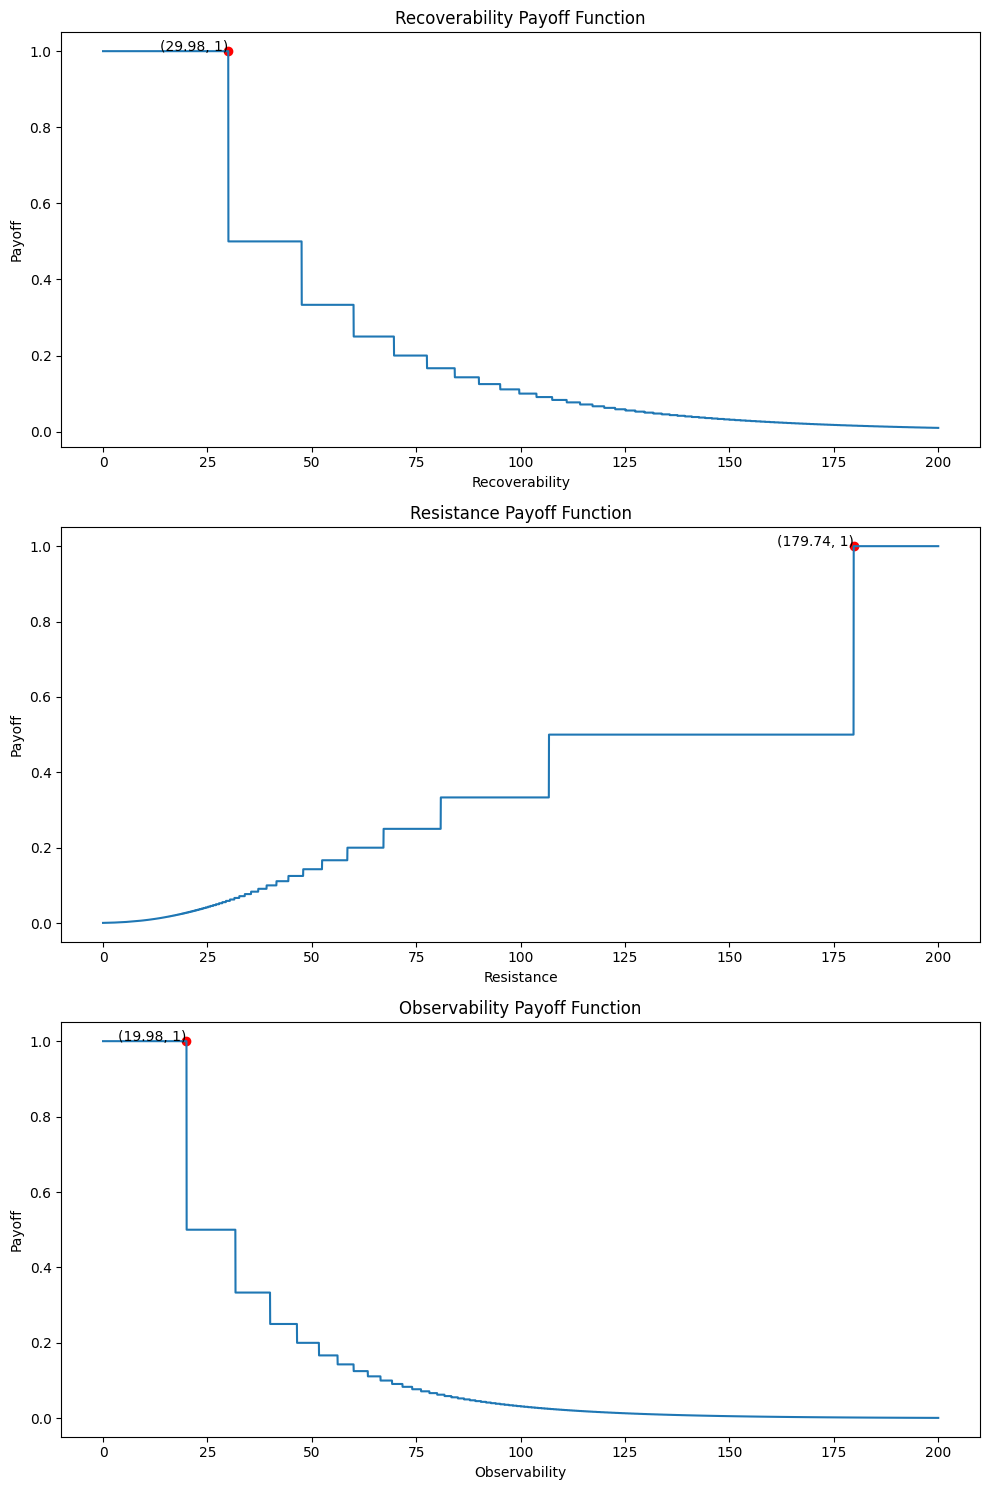

In [57]:

# Generate a range of possible metric values
metric_values = np.linspace(0.001, 200, 10000)  # Adjust this as needed
epsilon = 0.0001  # to avoid division by zero

# Calculate the cost function for each metric
recoverability_cost = np.floor(np.exp(metric_values / (30 / np.log(2))))-1

# expecting most of the recoveries taking between 50 and 140 seconds
# outliers that take longer to recover than the actual chaos time of 120s, should receive an extremely low score
# but should still be measurably better than systems that take even longer
recoverability_payoff = 1 / (1 + np.floor(np.exp(metric_values / (30 / np.log(2))))-1)
# resistance because a trial is 180 seconds, an if it fails at all during that time it should not be perfect
resistance_payoff = 1 / (1 + np.floor(np.exp((95 / np.log(2)) / (metric_values + 18)))-1)
# Alert needs to firing for 20 seconds before it is triggered, therefore observability of 20s should be perfect payoff
observability_payoff = 1 / (1 + np.floor(np.exp(metric_values / (20 / np.log(2))))-1)

# Calculate x_values for y=1 (or close to 1)
recoverability_x_for_y1 = metric_values[np.where(recoverability_payoff==1)[0][-1]]
resistance_x_for_y1 = metric_values[np.where(resistance_payoff==1)[0][0]]
observability_x_for_y1 = metric_values[np.where(observability_payoff==1)[0][-1]]

# Plot cost functions
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Recoverability
#ax[0].plot(metric_values, recoverability_cost)
#ax[0].set_title('Recoverability Cost Function')
#ax[0].set_xlabel('Recoverability')
#ax[0].set_ylabel('Cost')

# Recoverability Payoff with point at y=1
ax[0].plot(metric_values, recoverability_payoff)
ax[0].scatter(recoverability_x_for_y1, 1, color='red')  # Add point at y=1
ax[0].text(recoverability_x_for_y1, 1, f'({recoverability_x_for_y1:.2f}, 1)', ha='right')  # Add coordinates
ax[0].set_title('Recoverability Payoff Function')
ax[0].set_xlabel('Recoverability')
ax[0].set_ylabel('Payoff')

# Resistance Payoff with point at y=1
ax[1].plot(metric_values, resistance_payoff)
ax[1].scatter(resistance_x_for_y1, 1, color='red')  # Add point at y=1
ax[1].text(resistance_x_for_y1, 1, f'({resistance_x_for_y1:.2f}, 1)', ha='right')  # Add coordinates
ax[1].set_title('Resistance Payoff Function')
ax[1].set_xlabel('Resistance')
ax[1].set_ylabel('Payoff')

# Observability Payoff with point at y=1
ax[2].plot(metric_values, observability_payoff)
ax[2].scatter(observability_x_for_y1, 1, color='red')  # Add point at y=1
ax[2].text(observability_x_for_y1, 1, f'({observability_x_for_y1:.2f}, 1)', ha='right')  # Add coordinates
ax[2].set_title('Observability Payoff Function')
ax[2].set_xlabel('Observability')
ax[2].set_ylabel('Payoff')

plt.tight_layout()
plt.show()

## Calculate Antifragility Score

In [70]:
#experiment_data.style

In [59]:
load_ha_experiment_example = experiment_data.iloc[80:90]
load_ha_experiment_example.style

,chaosresult_name,start_time,inject_change,end_time,type,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,Resistance,Observability,Self-Organizing,Blast Radius,Scalability-Payoff,Fault Tolerance-Payoff,Recoverability-Payoff,Resistance-Payoff,Observability-Payoff,BlastRadius-Payoff,Self-Organizing-Payoff
80,increase_load_2_Trial1,2023-07-16 09:24:01,2023-07-16 09:25:02,2023-07-16 09:29:02,load,1,2023-07-16 09:25:40,2023-07-16 09:29:00,2023-07-16 09:26:10,0.760303,0.885593,200.000000,38.000000,30.000000,0.564784,2,0.760303,0.885593,0.009901,0.090909,0.500000,0.777778,0.564784
81,increase_load_2_Trial2,2023-07-16 09:29:02,2023-07-16 09:30:02,2023-07-16 09:34:02,load,1,2023-07-16 09:31:00,2023-07-16 09:31:10,2023-07-16 09:31:00,0.884771,0.919149,10.000000,58.000000,0.000000,0.033333,2,0.884771,0.919149,1.000000,0.166667,1.000000,0.777778,0.033333
82,increase_load_2_Trial3,2023-07-16 09:34:02,2023-07-16 09:35:02,2023-07-16 09:39:02,load,1,2023-07-16 09:37:20,2023-07-16 09:38:30,2023-07-16 09:37:20,0.962614,0.957527,70.000000,138.000000,0.000000,0.233333,0,0.962614,0.957527,0.200000,0.500000,1.000000,1.000000,0.233333
83,increase_load_2_Trial4,2023-07-16 09:39:02,2023-07-16 09:40:02,2023-07-16 09:44:02,load,1,2023-07-16 09:42:20,2023-07-16 09:44:10,NaT,0.970068,0.955882,110.000000,138.000000,1000.000000,nan,1,0.970068,0.955882,0.083333,0.500000,0.000000,0.888889,nan
84,increase_load_2_Trial5,2023-07-16 09:44:02,2023-07-16 09:45:02,2023-07-16 09:49:02,load,1,2023-07-16 09:47:00,2023-07-16 09:47:20,NaT,0.958835,0.966942,20.000000,118.000000,1000.000000,nan,0,0.958835,0.966942,1.000000,0.500000,0.000000,1.000000,nan
85,increase_load_2_Trial6,2023-07-16 09:49:02,2023-07-16 09:50:02,2023-07-16 09:54:03,load,1,2023-07-16 09:52:10,2023-07-16 09:52:50,NaT,0.974745,0.967480,40.000000,128.000000,1000.000000,nan,0,0.974745,0.967480,0.500000,0.500000,0.000000,1.000000,nan
86,increase_load_2_Trial7,2023-07-16 09:54:03,2023-07-16 09:55:03,2023-07-16 09:59:03,load,1,NaT,NaT,NaT,0.988947,0.981273,nan,1000.000000,nan,nan,0,0.988947,0.981273,nan,1.000000,nan,1.000000,nan
87,increase_load_2_Trial8,2023-07-16 09:59:03,2023-07-16 10:00:03,2023-07-16 10:04:03,load,1,NaT,NaT,NaT,0.972738,0.973485,nan,1000.000000,nan,nan,1,0.972738,0.973485,nan,1.000000,nan,0.888889,nan
88,increase_load_2_Trial9,2023-07-16 10:04:03,2023-07-16 10:05:03,2023-07-16 10:09:03,load,1,2023-07-16 10:05:50,2023-07-16 10:07:40,2023-07-16 10:06:30,0.950740,0.952000,110.000000,47.000000,40.000000,0.233333,1,0.950740,0.952000,0.083333,0.125000,0.250000,0.888889,0.233333
89,increase_load_2_Trial10,2023-07-16 10:09:03,2023-07-16 10:10:03,2023-07-16 10:14:03,load,1,2023-07-16 10:11:20,2023-07-16 10:11:30,NaT,0.968075,0.953668,10.000000,77.000000,1000.000000,nan,0,0.968075,0.953668,1.000000,0.250000,0.000000,1.000000,nan


In [60]:
# List of columns to calculate the adaptivity for
payoff_metrics = ["Scalability", "Fault Tolerance", "Recoverability", "Resistance", "Observability", "BlastRadius", "Self-Organizing"]

# Initialization of the resulting DataFrame
experiments_summary = pd.DataFrame(columns=["Experimenttype", "Group", "Start_time", "End_time"] + [f"{metric}-Adaptivity" for metric in payoff_metrics])


In [61]:
def calculate_adaptivity_score(experiment_group_data, metric):
    """Calculates adaptivity score for a specific metric."""
    adaptivity_score = 0
    trial_count = 0
    previous_payoff = np.nan
    payoff_column = f"{metric}-Payoff"
    
    for i, current_payoff in enumerate(experiment_group_data[payoff_column]):
        # Skip if the current payoff is NaN
        if np.isnan(current_payoff):
            continue  
        trial_count += 1
        current_payoff = round(current_payoff, 3)  # Round to 3 decimal points
    
        
        if np.isnan(previous_payoff):
            # Find the most recent non-NaN payoff
            previous_payoff = get_previous_payoff(experiment_group_data[payoff_column], i)
        
        
        # Ensure previous_payoff is also rounded to 3 decimal points
        previous_payoff = round(previous_payoff, 3) if not np.isnan(previous_payoff) else np.nan  
        
        
        
        if np.isnan(previous_payoff) or current_payoff == previous_payoff:  # neutral decision
            adaptivity_score += current_payoff
        elif current_payoff > previous_payoff:  # positive decision
            adaptivity_score += (current_payoff + previous_payoff) / 2
        # Negative decisions are ignored
        previous_payoff = current_payoff

    return adaptivity_score, trial_count

def get_previous_payoff(payoff_column_data, current_index):
    """Finds the most recent non-NaN payoff."""
    non_nan_payoffs = payoff_column_data.iloc[:current_index].dropna()
    previous_payoff = non_nan_payoffs.iloc[-1] if not non_nan_payoffs.empty else np.nan
    return previous_payoff

def summarize_experiment(experiment_data):
    """Creates summary for experiments."""
    payoff_metrics = ["Scalability", "Fault Tolerance", "Recoverability", "Resistance", "Observability", "BlastRadius", "Self-Organizing"]
    experiments_summary_list = []
    
    for (experiment_type, group), experiment_group_data in experiment_data.groupby(["type", "group"]):
        experiment_group_data = experiment_group_data.sort_values(by="start_time")
        start_time = experiment_group_data["start_time"].iloc[0]
        end_time = experiment_group_data["end_time"].iloc[-1]
        
        experiment_summary = {"Experimenttype": experiment_type, "Group": group, "Start_time": start_time, "End_time": end_time}
        for metric in payoff_metrics:
            adaptivity_score, trial_count = calculate_adaptivity_score(experiment_group_data, metric)
            adaptivity_score /= trial_count if trial_count != 0 else 1  # Calculate average, avoid division by zero
            if trial_count == 0:  # If all payoffs are NaN
                adaptivity_score = np.nan
            experiment_summary[f"{metric}-Adaptivity"] = adaptivity_score
        
        experiments_summary_list.append(experiment_summary)

    experiments_summary = pd.DataFrame(experiments_summary_list)
    return experiments_summary

# Run the function on the data
experiments_summary = summarize_experiment(experiment_data)

In [62]:
experiments_summary.style

,Experimenttype,Group,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
0,cpu,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.491050,0.526250,0.110100,0.146450,0.584100,0.666800,0.279500
1,cpu,1,2023-07-16 12:01:53,2023-07-16 13:05:09,0.431400,0.529450,0.180111,0.146750,0.228667,0.711200,0.312333
2,cpu,2,2023-07-17 01:43:46,2023-07-17 02:45:07,0.455400,0.654150,0.266500,0.217500,0.003875,0.555600,0.235000
3,cpu,3,2023-07-17 02:46:40,2023-07-17 03:50:01,0.452000,0.453350,0.110150,0.225900,0.309100,0.700100,0.204000
4,cpu,4,2023-07-17 03:51:35,2023-07-17 04:52:52,0.619550,0.463300,0.060350,0.057800,0.101550,0.694550,0.124750
5,cpu,5,2023-07-17 05:43:46,2023-07-17 08:15:59,0.691300,0.634700,0.073611,0.201350,0.127722,0.622300,0.142071
6,cpu,6,2023-07-17 08:44:10,2023-07-17 09:47:30,0.625800,0.559450,0.045875,0.304500,0.008500,0.550050,0.196500
7,cpu,7,2023-07-17 09:49:04,2023-07-17 10:52:18,0.527600,0.467700,0.054063,0.297150,0.064437,0.661150,0.210667
8,cpu,8,2023-07-17 11:43:46,2023-07-17 12:45:02,0.536700,0.462150,0.079611,0.273250,0.016833,0.550050,0.241667
9,cpu,9,2023-07-17 12:46:30,2023-07-17 13:47:48,0.459750,0.382300,0.236500,0.317000,0.002714,0.583350,0.098500


In [63]:
experiments_summary.sort_values(by="Start_time").style

,Experimenttype,Group,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
51,update,0,2023-07-15 18:05:27,2023-07-15 18:35:54,0.595100,0.695050,nan,1.000000,nan,1.000000,nan
42,load,0,2023-07-15 18:50:13,2023-07-15 19:40:15,0.530150,0.632000,0.063300,0.158600,0.875000,0.755700,0.331300
48,network,0,2023-07-15 19:56:00,2023-07-15 21:03:24,0.581700,0.590150,0.295875,0.500350,0.125000,0.444350,0.076000
49,network,1,2023-07-15 21:20:46,2023-07-15 22:38:16,0.595550,0.596800,0.244333,0.564800,0.000000,1.000000,nan
0,cpu,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.491050,0.526250,0.110100,0.146450,0.584100,0.666800,0.279500
44,memory,0,2023-07-16 00:35:51,2023-07-16 01:37:07,0.575800,0.584650,0.164900,0.461500,0.000000,0.777800,nan
45,memory,1,2023-07-16 01:43:47,2023-07-16 02:45:03,0.684400,0.687800,0.666667,0.737500,0.000000,0.427950,nan
39,delete,0,2023-07-16 07:33:25,2023-07-16 08:54:38,0.393050,0.493450,nan,1.000000,nan,0.894450,nan
43,load,1,2023-07-16 09:24:01,2023-07-16 10:14:03,0.638150,0.658250,0.199750,0.399100,0.296875,0.722300,0.232750
50,network,2,2023-07-16 10:30:47,2023-07-16 11:45:09,0.696100,0.697050,1.000000,0.850450,0.000000,0.900000,nan


In [64]:
experiment_data.describe()

,start_time,inject_change,end_time,group,fail_init,fail_end,fail_detect,Scalability,Fault Tolerance,Recoverability,...,Observability,Self-Organizing,Blast Radius,Scalability-Payoff,Fault Tolerance-Payoff,Recoverability-Payoff,Resistance-Payoff,Observability-Payoff,BlastRadius-Payoff,Self-Organizing-Payoff
count,530,530,530,530.000000,400,400,245,530.000000,530.000000,400.000000,...,400.000000,245.000000,530.000000,530.000000,530.000000,400.000000,530.000000,4.000000e+02,530.000000,245.000000
mean,2023-07-17 18:43:13.760377344,2023-07-17 18:45:32.652830208,2023-07-17 18:48:48.911320832,14.245283,2023-07-18 01:39:58.525000192,2023-07-18 01:42:19.824999936,2023-07-18 07:09:58.857143040,0.877794,0.927086,141.300000,...,414.925000,0.409783,1.049057,0.877794,0.927086,0.165502,0.420494,3.189651e-01,0.883438,0.409783
min,2023-07-15 18:05:27,2023-07-15 18:06:00,2023-07-15 18:08:30,0.000000,2023-07-15 18:52:40,2023-07-15 18:54:50,2023-07-15 18:52:40,0.263378,0.691489,10.000000,...,0.000000,0.000000,0.000000,0.263378,0.691489,0.000010,0.000494,8.881784e-16,0.222222,0.000000
25%,2023-07-16 16:12:21.500000,2023-07-16 16:12:53.750000128,2023-07-16 16:15:23.750000128,2.000000,2023-07-17 09:44:30,2023-07-17 09:46:47.500000,2023-07-17 16:38:40,0.831866,0.889992,100.000000,...,10.000000,0.272727,0.000000,0.831866,0.889992,0.009901,0.111111,8.881784e-16,0.777778,0.272727
50%,2023-07-17 20:11:41,2023-07-17 20:13:56.500000,2023-07-17 20:17:11.500000,12.000000,2023-07-18 02:46:55,2023-07-18 02:48:30,2023-07-18 08:39:10,0.899217,0.931031,150.000000,...,100.000000,0.363636,1.000000,0.899217,0.931031,0.031250,0.250000,3.125000e-02,0.888889,0.363636
75%,2023-07-18 22:25:37,2023-07-18 22:27:52,2023-07-18 22:31:07.750000128,25.000000,2023-07-19 02:05:07.500000,2023-07-19 02:08:10,2023-07-19 04:45:10,0.962587,0.969808,200.000000,...,1000.000000,0.545455,2.000000,0.962587,0.969808,0.100000,1.000000,1.000000e+00,1.000000,0.545455
max,2023-07-19 14:42:32,2023-07-19 14:44:47,2023-07-19 14:48:03,38.000000,2023-07-19 14:45:00,2023-07-19 14:45:40,2023-07-19 14:46:00,1.000000,1.000000,500.000000,...,1000.000000,1.666667,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.666667
std,NaN,NaN,NaN,12.518275,NaN,NaN,NaN,0.112081,0.051867,73.213459,...,467.436881,0.214671,1.001629,0.112081,0.051867,0.293473,0.370218,4.235607e-01,0.111292,0.214671


## Group by system

In [65]:
column_index = experiments_summary.columns.get_loc('Group')+1
experiments_summary.insert(column_index, 'System', None)


In [66]:
# Define the conditions and set the 'System' column accordingly
start_time = pd.to_datetime('2023-07-16 08:54:38') # HA version start
end_time_1 = pd.to_datetime('2023-07-18 00:58') # Non-HA Version Start
end_time_2 = pd.to_datetime('2023-07-18 12:05') # HA Version Start
end_time_3 = pd.to_datetime('2023-07-18 20:52') # Non-HA Version Start

experiments_summary.loc[experiments_summary['Start_time'] < start_time, 'System'] = 0
experiments_summary.loc[(experiments_summary['Start_time'] >= start_time) & (experiments_summary['Start_time'] < end_time_1), 'System'] = 1
experiments_summary.loc[(experiments_summary['Start_time'] >= end_time_1) & (experiments_summary['Start_time'] < end_time_2), 'System'] = 0
experiments_summary.loc[(experiments_summary['Start_time'] >= end_time_2) & (experiments_summary['Start_time'] < end_time_3), 'System'] = 1
experiments_summary.loc[experiments_summary['Start_time'] >= end_time_3, 'System'] = 0

In [67]:
experiments_summary.style

,Experimenttype,Group,System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
0,cpu,0,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.491050,0.526250,0.110100,0.146450,0.584100,0.666800,0.279500
1,cpu,1,1,2023-07-16 12:01:53,2023-07-16 13:05:09,0.431400,0.529450,0.180111,0.146750,0.228667,0.711200,0.312333
2,cpu,2,1,2023-07-17 01:43:46,2023-07-17 02:45:07,0.455400,0.654150,0.266500,0.217500,0.003875,0.555600,0.235000
3,cpu,3,1,2023-07-17 02:46:40,2023-07-17 03:50:01,0.452000,0.453350,0.110150,0.225900,0.309100,0.700100,0.204000
4,cpu,4,1,2023-07-17 03:51:35,2023-07-17 04:52:52,0.619550,0.463300,0.060350,0.057800,0.101550,0.694550,0.124750
5,cpu,5,1,2023-07-17 05:43:46,2023-07-17 08:15:59,0.691300,0.634700,0.073611,0.201350,0.127722,0.622300,0.142071
6,cpu,6,1,2023-07-17 08:44:10,2023-07-17 09:47:30,0.625800,0.559450,0.045875,0.304500,0.008500,0.550050,0.196500
7,cpu,7,1,2023-07-17 09:49:04,2023-07-17 10:52:18,0.527600,0.467700,0.054063,0.297150,0.064437,0.661150,0.210667
8,cpu,8,1,2023-07-17 11:43:46,2023-07-17 12:45:02,0.536700,0.462150,0.079611,0.273250,0.016833,0.550050,0.241667
9,cpu,9,1,2023-07-17 12:46:30,2023-07-17 13:47:48,0.459750,0.382300,0.236500,0.317000,0.002714,0.583350,0.098500


In [68]:
system_1 = experiments_summary[experiments_summary['System']==0]
system_2 = experiments_summary[experiments_summary['System']==1]

## System Comparison

In [69]:
# filter to only relevant experiments for comparison
start_system_1_assessment = pd.to_datetime("2023-07-15 18:05:27")
end_system_1_assessment = pd.to_datetime("2023-07-16 07:33:25")
system_1 = system_1[(system_1['Start_time']>= start_system_1_assessment) & (system_1['Start_time'] <= end_system_1_assessment)]

system_1 = system_1.drop(system_1[(system_1['Experimenttype']=="network") & (system_1['Group']==0)].index)

# filter to only relevant experiments for comparison
start_system_2_assessment = pd.to_datetime("2023-07-16 09:24:01")
end_system_2_assessment = pd.to_datetime("2023-07-18 14:58:56")
system_2 = system_2[(system_2['Start_time']>= start_system_2_assessment) & (system_2['Start_time'] <= end_system_2_assessment)]

system_2 = system_2.drop(system_2[(system_2['Experimenttype']=="cpu") & (system_2['Group']>=2)].index)


In [70]:
system_1

,Experimenttype,Group,System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
0,cpu,0,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.49105,0.52625,0.110100,0.14645,0.5841,0.66680,0.2795
39,delete,0,0,2023-07-16 07:33:25,2023-07-16 08:54:38,0.39305,0.49345,NaN,1.00000,NaN,0.89445,NaN
42,load,0,0,2023-07-15 18:50:13,2023-07-15 19:40:15,0.53015,0.63200,0.063300,0.15860,0.8750,0.75570,0.3313
44,memory,0,0,2023-07-16 00:35:51,2023-07-16 01:37:07,0.57580,0.58465,0.164900,0.46150,0.0000,0.77780,NaN
45,memory,1,0,2023-07-16 01:43:47,2023-07-16 02:45:03,0.68440,0.68780,0.666667,0.73750,0.0000,0.42795,NaN
49,network,1,0,2023-07-15 21:20:46,2023-07-15 22:38:16,0.59555,0.59680,0.244333,0.56480,0.0000,1.00000,NaN
51,update,0,0,2023-07-15 18:05:27,2023-07-15 18:35:54,0.59510,0.69505,NaN,1.00000,NaN,1.00000,NaN


In [71]:
summary_columns = ["Scalability-Adaptivity", "Fault Tolerance-Adaptivity", "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", "BlastRadius-Adaptivity", "Self-Organizing-Adaptivity"]

def calculate_summary(data, system_name):

    # Calculate the mean and standard deviation for each column
    mean = data[summary_columns].mean()
    std_dev = data[summary_columns].std()

    # Create a DataFrame from these and add a 'System' column
    summary = pd.DataFrame(data=[mean, std_dev], index=['mean', 'std_dev'])
    summary['System'] = system_name
    return summary

# Calculate summaries for each system
summary_system_1 = calculate_summary(system_1, 'System 1')
summary_system_2 = calculate_summary(system_2, 'System 2')

# Concatenate these summaries into one DataFrame
summary_table = pd.concat([summary_system_1, summary_system_2])

# Rearrange columns
summary_table = summary_table[['System'] + summary_columns]

In [89]:
summary_table.style

,System,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
mean,System 1,0.552157,0.602286,0.249860,0.643514,0.291820,0.788957,0.305400
std_dev,System 1,0.092473,0.076123,0.242546,0.301893,0.412615,0.202767,0.036628
mean,System 2,0.676279,0.695136,0.430622,0.746057,0.105108,0.799264,0.272542
std_dev,System 2,0.172417,0.149302,0.342720,0.277771,0.145932,0.142739,0.056274


In [73]:
print(system_1)

   Experimenttype  Group System          Start_time            End_time  \
0             cpu      0      0 2023-07-15 23:03:45 2023-07-16 00:05:03   
39         delete      0      0 2023-07-16 07:33:25 2023-07-16 08:54:38   
42           load      0      0 2023-07-15 18:50:13 2023-07-15 19:40:15   
44         memory      0      0 2023-07-16 00:35:51 2023-07-16 01:37:07   
45         memory      1      0 2023-07-16 01:43:47 2023-07-16 02:45:03   
49        network      1      0 2023-07-15 21:20:46 2023-07-15 22:38:16   
51         update      0      0 2023-07-15 18:05:27 2023-07-15 18:35:54   

    Scalability-Adaptivity  Fault Tolerance-Adaptivity  \
0                  0.49105                     0.52625   
39                 0.39305                     0.49345   
42                 0.53015                     0.63200   
44                 0.57580                     0.58465   
45                 0.68440                     0.68780   
49                 0.59555                     0.59

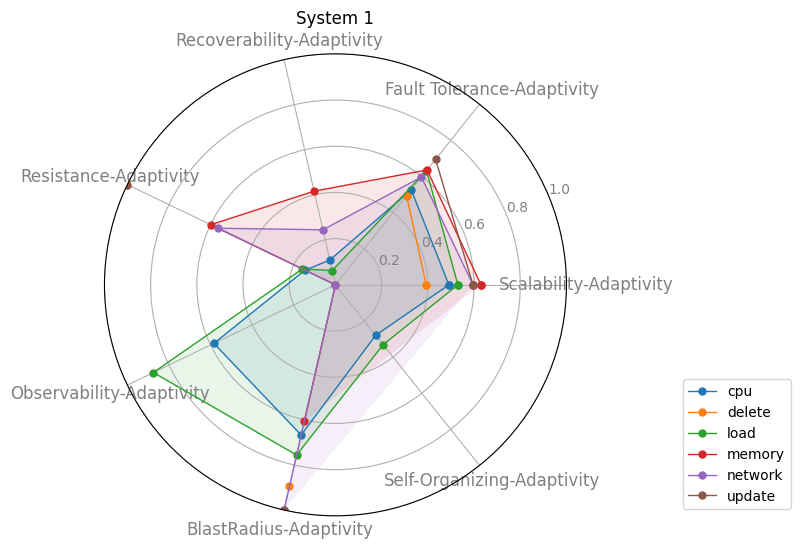

In [74]:
# Select relevant columns
data = system_1[["Experimenttype", "Scalability-Adaptivity", "Fault Tolerance-Adaptivity",
                      "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", 
                      "BlastRadius-Adaptivity", "Self-Organizing-Adaptivity"]]

# Aggregate data by Experimenttype and take the mean
data = data.groupby('Experimenttype').mean().reset_index()

# Number of variable
categories = list(data)[1:]
N = len(categories)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]  # Ensure the plot is a complete circle

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Loop to add each experimenttype to the plot
for i, row in data.iterrows():
    values = row.drop('Experimenttype').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', marker='o', markersize=5, label=row['Experimenttype'])
    ax.fill(angles, values, alpha=0.1)

# Add legend and labels
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(color="grey", size=10)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))
plt.title("System 1")

# Set radial axis limits
ax.set_ylim(0, 1)

plt.show()


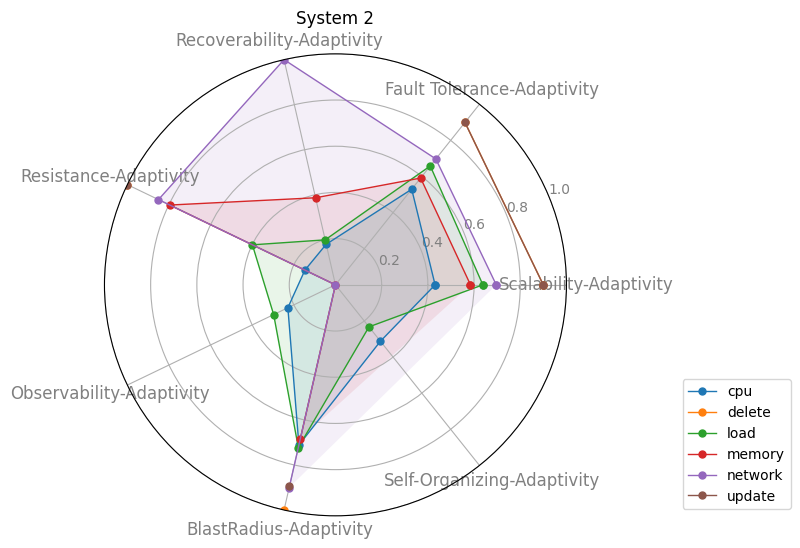

In [75]:
# Select relevant columns
data = system_2[["Experimenttype", "Scalability-Adaptivity", "Fault Tolerance-Adaptivity",
                      "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", 
                      "BlastRadius-Adaptivity", "Self-Organizing-Adaptivity"]]

# Aggregate data by Experimenttype and take the mean
data = data.groupby('Experimenttype').mean().reset_index()

# Number of variable
categories = list(data)[1:]
N = len(categories)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]  # Ensure the plot is a complete circle

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Loop to add each experimenttype to the plot
for i, row in data.iterrows():
    values = row.drop('Experimenttype').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', marker='o', markersize=5, label=row['Experimenttype'])
    ax.fill(angles, values, alpha=0.1)

# Add legend and labels
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(color="grey", size=10)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))
plt.title("System 2")

# Set radial axis limits
ax.set_ylim(0, 1)

plt.show()


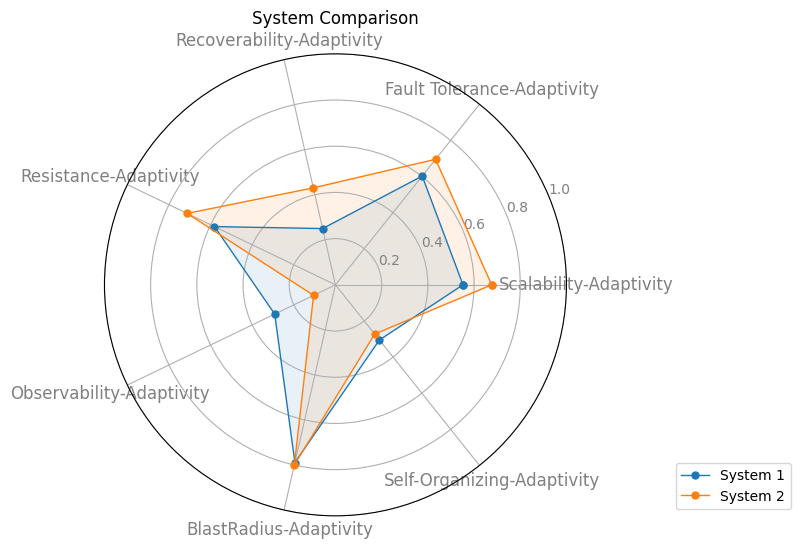

In [76]:
# Select relevant columns
data = summary_table[["System", "Scalability-Adaptivity", "Fault Tolerance-Adaptivity",
                      "Recoverability-Adaptivity", "Resistance-Adaptivity", "Observability-Adaptivity", 
                      "BlastRadius-Adaptivity", "Self-Organizing-Adaptivity"]]

# Drop rows with label "std_dev"
data = data.drop('std_dev', axis=0)

# Aggregate data by Experimenttype and take the mean
data = data.groupby('System').mean().reset_index()

# Number of variable
categories = list(data)[1:]
N = len(categories)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]  # Ensure the plot is a complete circle

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Loop to add each experimenttype to the plot
for i, row in data.iterrows():
    values = row.drop('System').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', marker='o', markersize=5, label=row['System'])
    ax.fill(angles, values, alpha=0.1)

# Add legend and labels
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks(color="grey", size=10)
plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))
plt.title("System Comparison")

# Set radial axis limits
ax.set_ylim(0, 1)

plt.show()


In [77]:
summary_table.style

,System,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
mean,System 1,0.552157,0.602286,0.249860,0.581264,0.291820,0.788957,0.305400
std_dev,System 1,0.092473,0.076123,0.242546,0.355296,0.412615,0.202767,0.036628
mean,System 2,0.676279,0.695136,0.430622,0.712636,0.105108,0.799264,0.272542
std_dev,System 2,0.172417,0.149302,0.342720,0.322691,0.145932,0.142739,0.056274


In [78]:
print(summary_table)

           System  Scalability-Adaptivity  Fault Tolerance-Adaptivity  \
mean     System 1                0.552157                    0.602286   
std_dev  System 1                0.092473                    0.076123   
mean     System 2                0.676279                    0.695136   
std_dev  System 2                0.172417                    0.149302   

         Recoverability-Adaptivity  Resistance-Adaptivity  \
mean                      0.249860               0.581264   
std_dev                   0.242546               0.355296   
mean                      0.430622               0.712636   
std_dev                   0.342720               0.322691   

         Observability-Adaptivity  BlastRadius-Adaptivity  \
mean                     0.291820                0.788957   
std_dev                  0.412615                0.202767   
mean                     0.105108                0.799264   
std_dev                  0.145932                0.142739   

         Self-Organizi

In [79]:
final_score = summary_table
final_score = final_score.drop('std_dev', axis=0)
final_score['Antifragility-Score'] = final_score.loc[:, 'Scalability-Adaptivity':"Self-Organizing-Adaptivity"].mean(axis=1)
final_score['Antifragility-Score-Std_dev'] = final_score.loc[:, 'Scalability-Adaptivity':"Self-Organizing-Adaptivity"].std(axis=1)

In [80]:
final_score.style

,System,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity,Antifragility-Score,Antifragility-Score-Std_dev
mean,System 1,0.552157,0.602286,0.249860,0.581264,0.291820,0.788957,0.305400,0.481678,0.201953
mean,System 2,0.676279,0.695136,0.430622,0.712636,0.105108,0.799264,0.272542,0.527370,0.261780


## Evaluation: Validity

In [81]:
system_1 = experiments_summary[experiments_summary['System']==0]
system_2 = experiments_summary[experiments_summary['System']==1]

In [82]:
system_1_cpu = system_1[system_1['Experimenttype']=="cpu"]

In [83]:
system_2_cpu = system_2[system_2['Experimenttype']=="cpu"]

In [84]:
sample_size_cpu = min(len(system_1_cpu),len(system_2_cpu))
sample_size_cpu

17

In [85]:
cpu_assessment = pd.DataFrame()
cpu_assessment = pd.concat([system_1_cpu[0:sample_size_cpu], system_2_cpu[0:sample_size_cpu]])
cpu_assessment.describe()

,Group,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
count,34.000000,34,34,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,16.500000,2023-07-18 00:23:13.676470528,2023-07-18 01:27:38.970588160,0.499925,0.524503,0.097239,0.192501,0.208361,0.654338,0.233895
min,0.000000,2023-07-15 23:03:45,2023-07-16 00:05:03,0.331100,0.345350,0.005900,0.043350,0.000687,0.494550,0.073000
25%,8.250000,2023-07-17 11:59:27,2023-07-17 13:00:43.500000,0.452175,0.455550,0.039913,0.132538,0.029929,0.586225,0.189375
50%,16.500000,2023-07-17 22:47:03.500000,2023-07-17 23:48:49.500000,0.483350,0.527850,0.072000,0.187950,0.154562,0.652925,0.238333
75%,24.750000,2023-07-18 18:30:12.249999872,2023-07-18 19:31:31,0.558313,0.612263,0.130578,0.269275,0.324987,0.689000,0.286109
max,33.000000,2023-07-19 07:43:46,2023-07-19 08:45:02,0.691300,0.702550,0.340250,0.370800,0.660650,0.900100,0.364000
std,9.958246,NaN,NaN,0.089683,0.093765,0.081191,0.090575,0.194730,0.092134,0.070051


In [86]:
cpu_assessment['Antifragility Score'] = cpu_assessment[['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
                                                       'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity"]].mean(axis=1)

cpu_assessment_sorted_ascending = cpu_assessment.sort_values(by='Antifragility Score', ascending=True)

system_classification = [0] * 17 + [1] * 17

cpu_assessment_sorted_ascending.insert(cpu_assessment_sorted_ascending.columns.get_loc('System') + 1, 'Classified System', system_classification)
cpu_assessment_sorted_ascending['System'] = cpu_assessment_sorted_ascending['System'].astype(int)

cpu_assessment_sorted_ascending.style

,Experimenttype,Group,System,Classified System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity,Antifragility Score
32,cpu,32,0,0,2023-07-19 05:52:16,2023-07-19 06:53:33,0.386650,0.546000,0.122950,0.214850,0.102750,0.505650,0.159167,0.291145
9,cpu,9,1,0,2023-07-17 12:46:30,2023-07-17 13:47:48,0.459750,0.382300,0.236500,0.317000,0.002714,0.583350,0.098500,0.297159
13,cpu,13,1,0,2023-07-17 17:50:19,2023-07-17 18:53:37,0.359600,0.377100,0.178500,0.188000,0.055778,0.650050,0.307500,0.302361
4,cpu,4,1,0,2023-07-17 03:51:35,2023-07-17 04:52:52,0.619550,0.463300,0.060350,0.057800,0.101550,0.694550,0.124750,0.303121
28,cpu,28,0,0,2023-07-19 00:52:08,2023-07-19 01:53:28,0.375250,0.513750,0.005900,0.048300,0.389050,0.494550,0.302850,0.304236
16,cpu,16,1,0,2023-07-17 21:50:21,2023-07-17 22:52:37,0.452700,0.471400,0.079000,0.187900,0.007150,0.661150,0.272000,0.304471
8,cpu,8,1,0,2023-07-17 11:43:46,2023-07-17 12:45:02,0.536700,0.462150,0.079611,0.273250,0.016833,0.550050,0.241667,0.308609
25,cpu,25,0,0,2023-07-18 21:43:46,2023-07-18 22:45:05,0.582150,0.450400,0.044600,0.100400,0.128800,0.672350,0.207786,0.312355
20,cpu,20,0,0,2023-07-18 03:49:23,2023-07-18 04:50:42,0.653850,0.362300,0.022750,0.147700,0.181250,0.650150,0.185250,0.314750
19,cpu,19,0,0,2023-07-18 02:46:39,2023-07-18 03:47:57,0.331100,0.451350,0.109200,0.130250,0.183450,0.772350,0.248556,0.318037


In [87]:
f"Percentage of correctly identified Systems: {(cpu_assessment_sorted_ascending['System']==cpu_assessment_sorted_ascending['Classified System']).sum()/len(cpu_assessment_sorted_ascending)*100}"

'Percentage of correctly identified Systems: 41.17647058823529'

### F-Score

In [88]:
y_true = cpu_assessment_sorted_ascending["System"]
y_pred = cpu_assessment_sorted_ascending["Classified System"]

precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F-Score:", fscore)

Precision: 0.4117647058823529
Recall: 0.4117647058823529
F-Score: 0.4117647058823529


In [89]:
cpu_assessment_sorted_ascending.sort_values(by='System', ascending=True)["Classified System"]
cpu_assessment_sorted_ascending.sort_values(by='System', ascending=True)["Classified System"][0:17].sum()

10

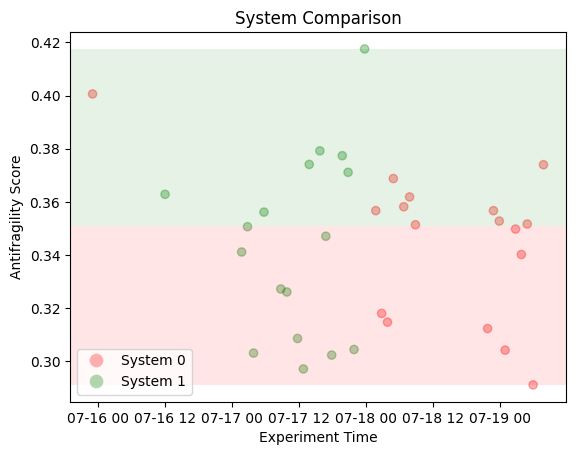

In [90]:

# Calculate the median score
median_score = cpu_assessment_sorted_ascending['Antifragility Score'].median()

# Create a mask to identify the color based on the 'System' column
colors = np.where(cpu_assessment_sorted_ascending['System'] == 1, 'green', 'red')

# Create the scatter plot
plt.scatter(cpu_assessment_sorted_ascending['Start_time'],
            cpu_assessment_sorted_ascending['Antifragility Score'],
            c=colors,
            alpha=0.3)

# Add color bands above and below the median score
plt.axhspan(median_score, cpu_assessment_sorted_ascending['Antifragility Score'].max(), facecolor='green', alpha=0.1, label='Above Median')
plt.axhspan(cpu_assessment_sorted_ascending['Antifragility Score'].min(), median_score, facecolor='red', alpha=0.1, label='Below Median')

# Set labels and title
plt.xlabel('Experiment Time')
plt.ylabel('Antifragility Score')
plt.title('System Comparison')

# Create custom legend handles and labels
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, markeredgewidth=0.5, alpha=0.3),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, markeredgewidth=0.5, alpha=0.3)
]
legend_labels = ['System 0', 'System 1']

# Add the custom legend
plt.legend(legend_handles, legend_labels, loc='lower left')

# Show the plot
plt.show()

## Try cluster algorithm instead of basic average

In [91]:
cpu_assessment
# Select the columns for clustering
dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity"]
data = cpu_assessment[dimensions]

# Create an instance of the KMeans clustering algorithm with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit the data to the KMeans model
kmeans.fit(data)

# Retrieve the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
cpu_assessment['Cluster'] = labels

# Print the resulting DataFrame with the cluster labels
# cpu_assessment[['System','Cluster']]

cpu_assessment["System"] = cpu_assessment["System"].astype(int)

y_true = cpu_assessment["System"]
y_pred = cpu_assessment["Cluster"]

precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F-Score:", fscore)

Precision: 0.08333333333333333
Recall: 0.058823529411764705
F-Score: 0.06896551724137931


/home/rubinatore/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/rubinatore/myenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


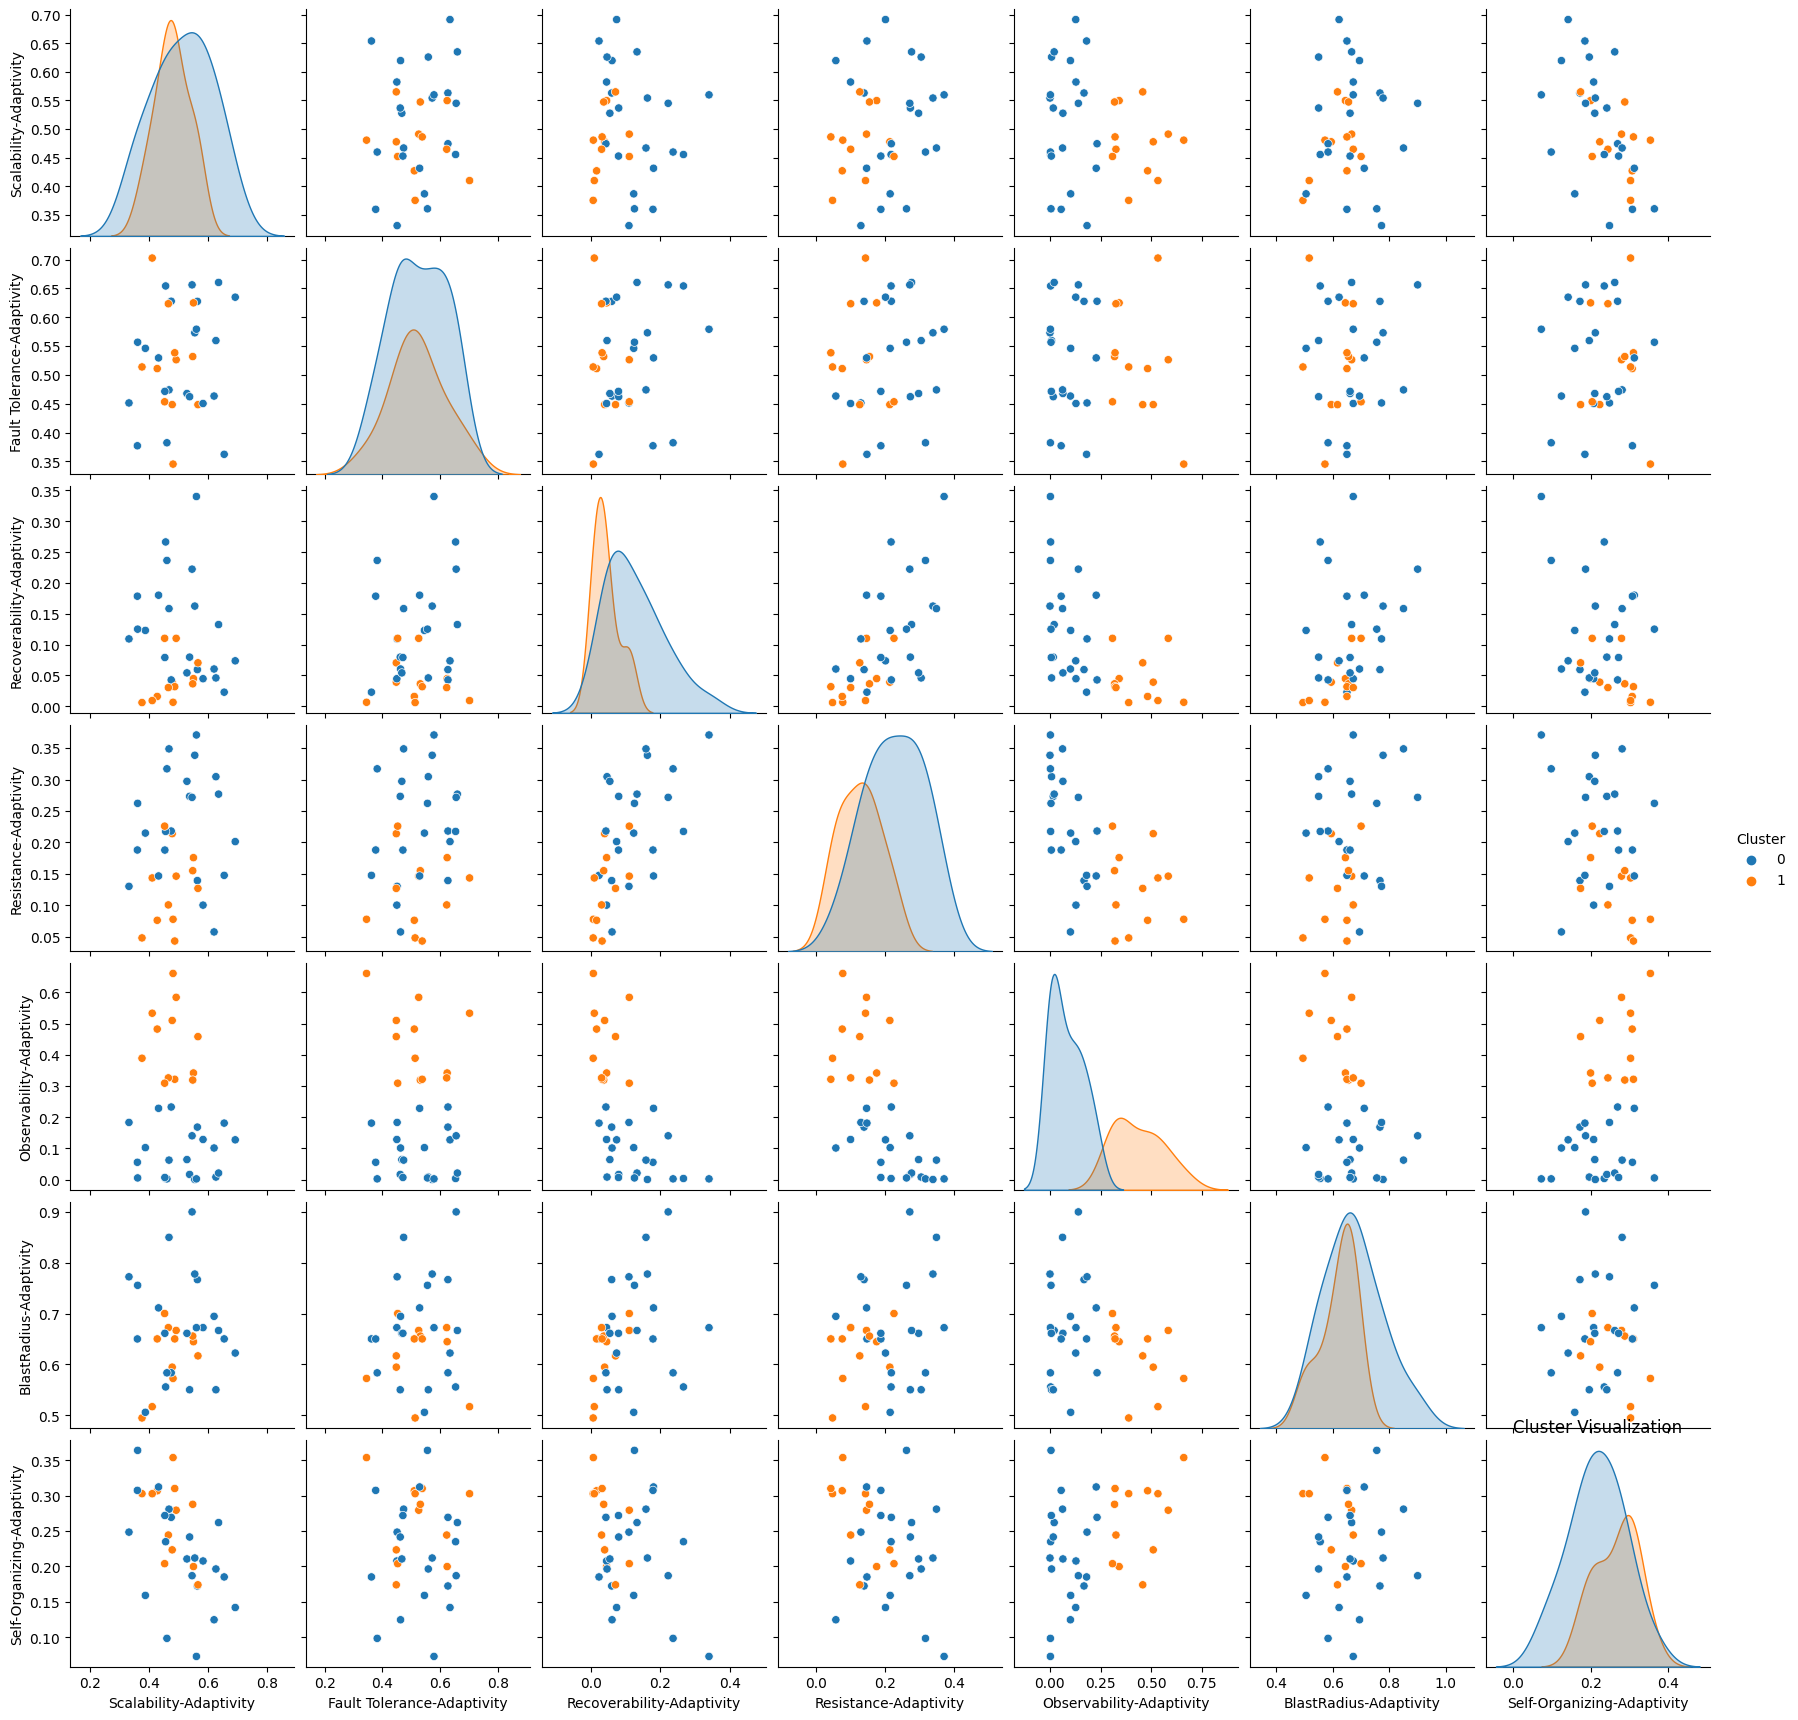

In [92]:
dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity", 'Cluster']

# Creating a pair plot with color-coded clusters
sns.pairplot(cpu_assessment[dimensions], hue='Cluster')
plt.title('Cluster Visualization')
plt.show()

### Actual distributions

#### For CPU

/home/rubinatore/myenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


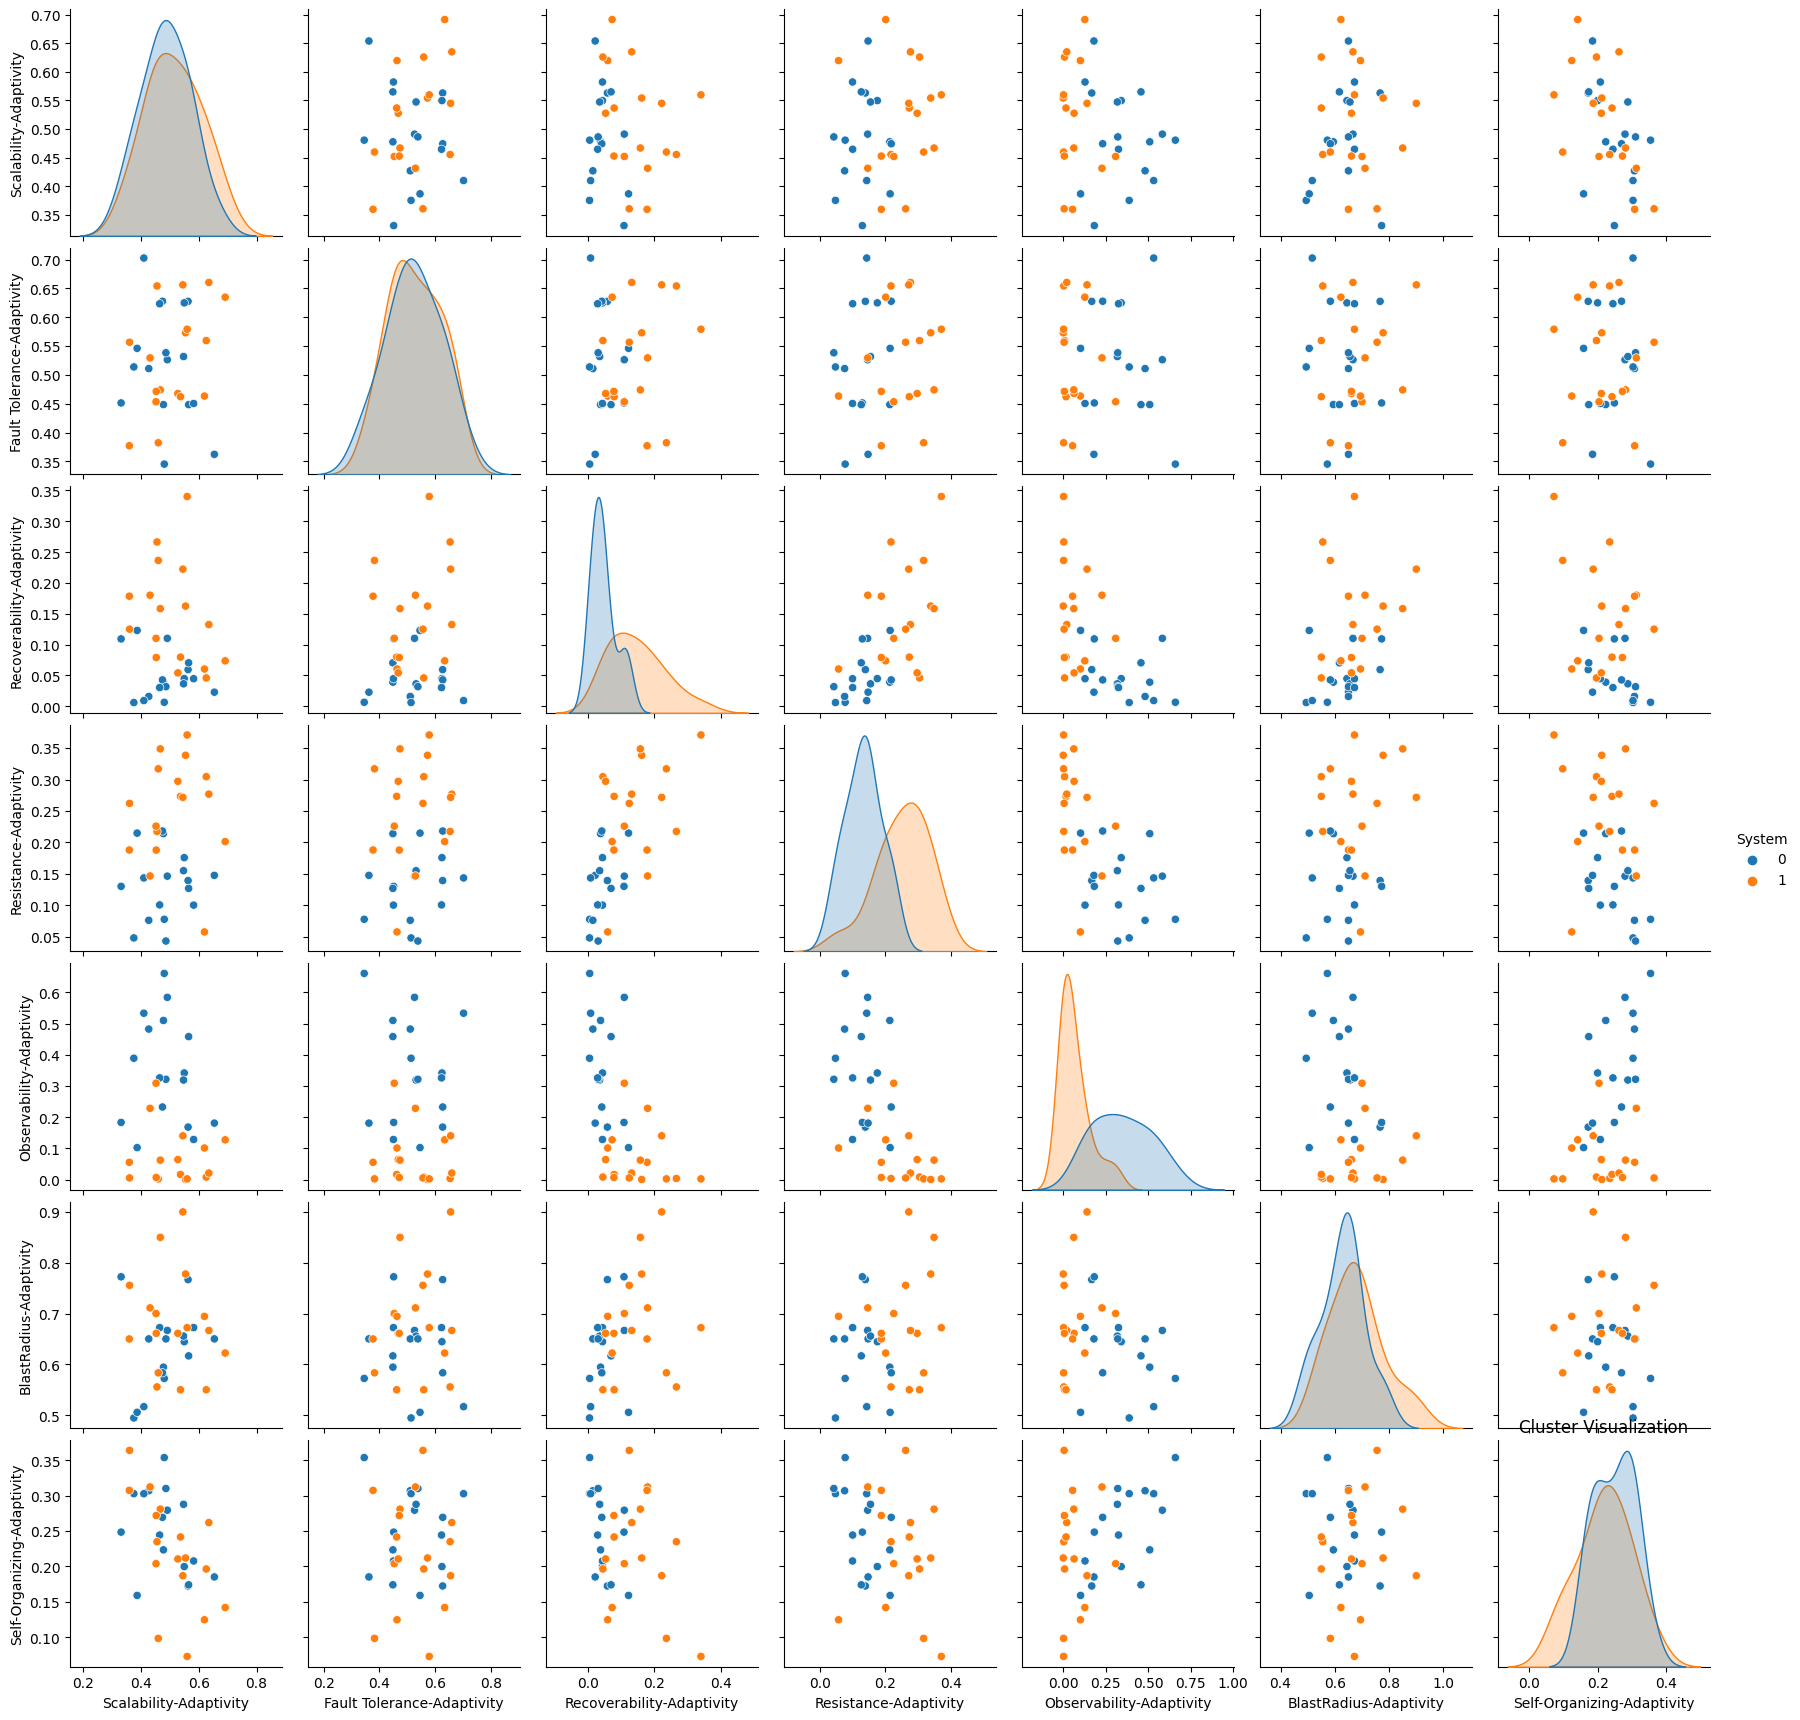

In [93]:
dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity", 'System']

# Creating a pair plot with color-coded clusters
sns.pairplot(cpu_assessment[dimensions], hue='System')
plt.title('Cluster Visualization')
plt.show()

#### For all experiments

/home/rubinatore/myenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


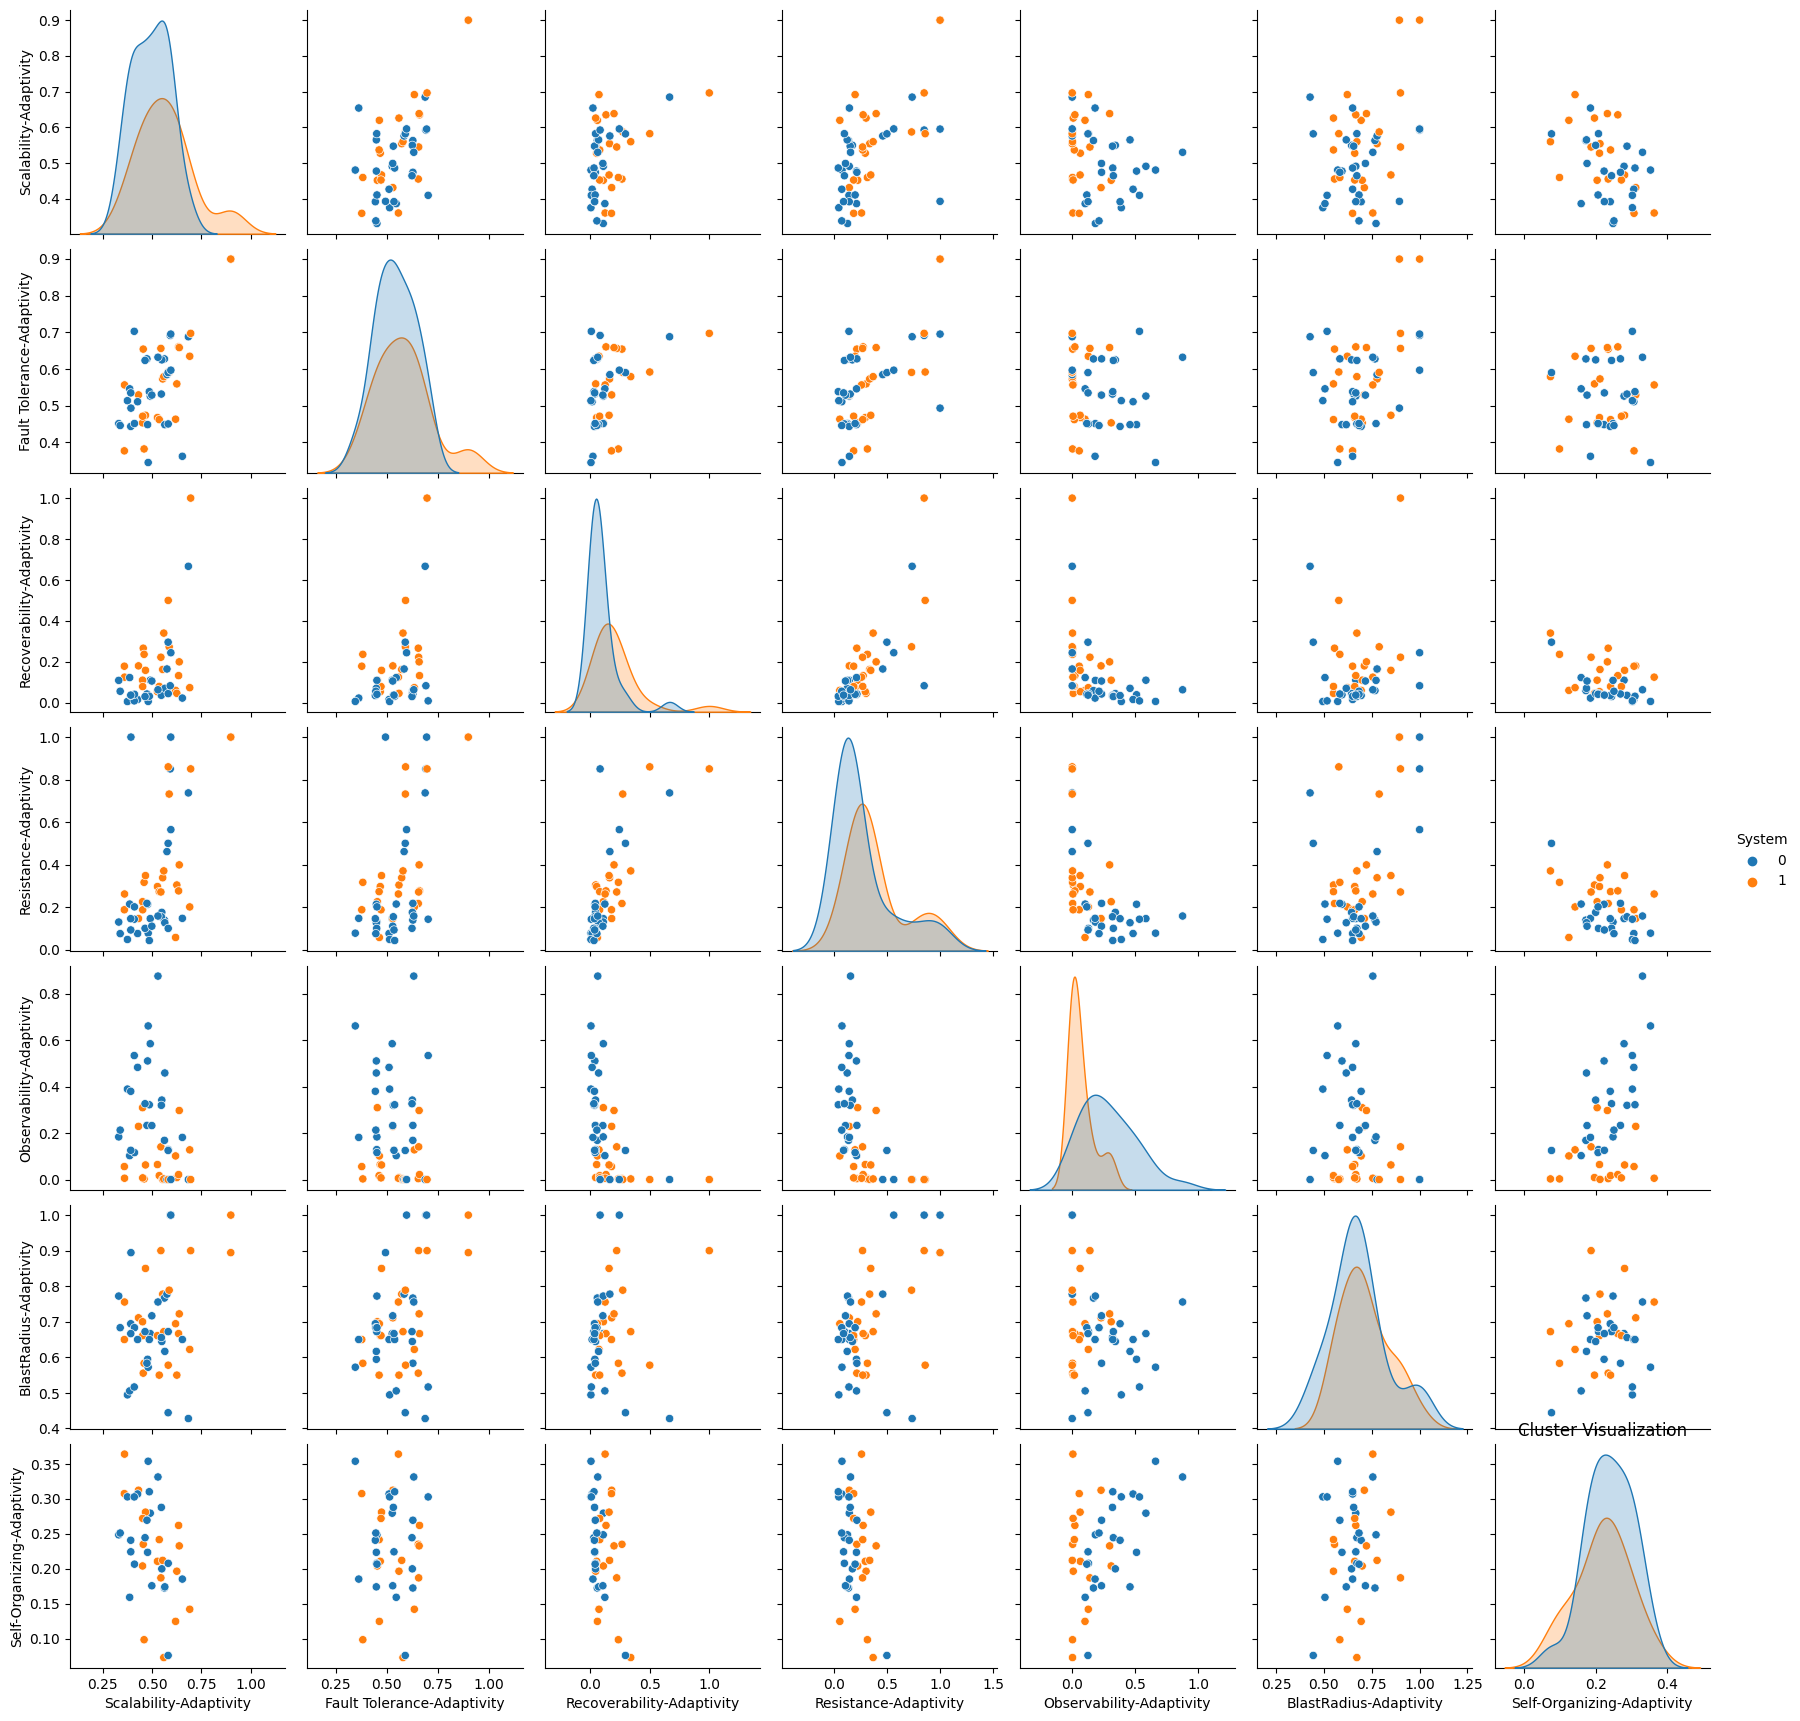

In [94]:
# Assuming you have a DataFrame called 'cpu_assessment' with a 'Cluster' column

dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity", 'System']

# Creating a pair plot with color-coded clusters
sns.pairplot(experiments_summary[dimensions], hue='System')
plt.title('Cluster Visualization')
plt.show()

#### Cluster across all experiments

In [95]:
experiment_summary_clusterd = experiments_summary.fillna(1)
# Select the columns for clustering
dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity"]
data = experiment_summary_clusterd[dimensions]

# Create an instance of the KMeans clustering algorithm with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit the data to the KMeans model
kmeans.fit(data)

# Retrieve the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
experiment_summary_clusterd['Cluster'] = labels

# Print the resulting DataFrame with the cluster labels
# cpu_assessment[['System','Cluster']]

experiment_summary_clusterd["System"] = experiment_summary_clusterd["System"].astype(int)

y_true = experiment_summary_clusterd["System"]
y_pred = experiment_summary_clusterd["Cluster"]

precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print("Precision:", precision)
print("Recall:", recall)
print("F-Score:", fscore)

Precision: 0.45454545454545453
Recall: 0.21739130434782608
F-Score: 0.29411764705882354


/home/rubinatore/myenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/rubinatore/myenv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


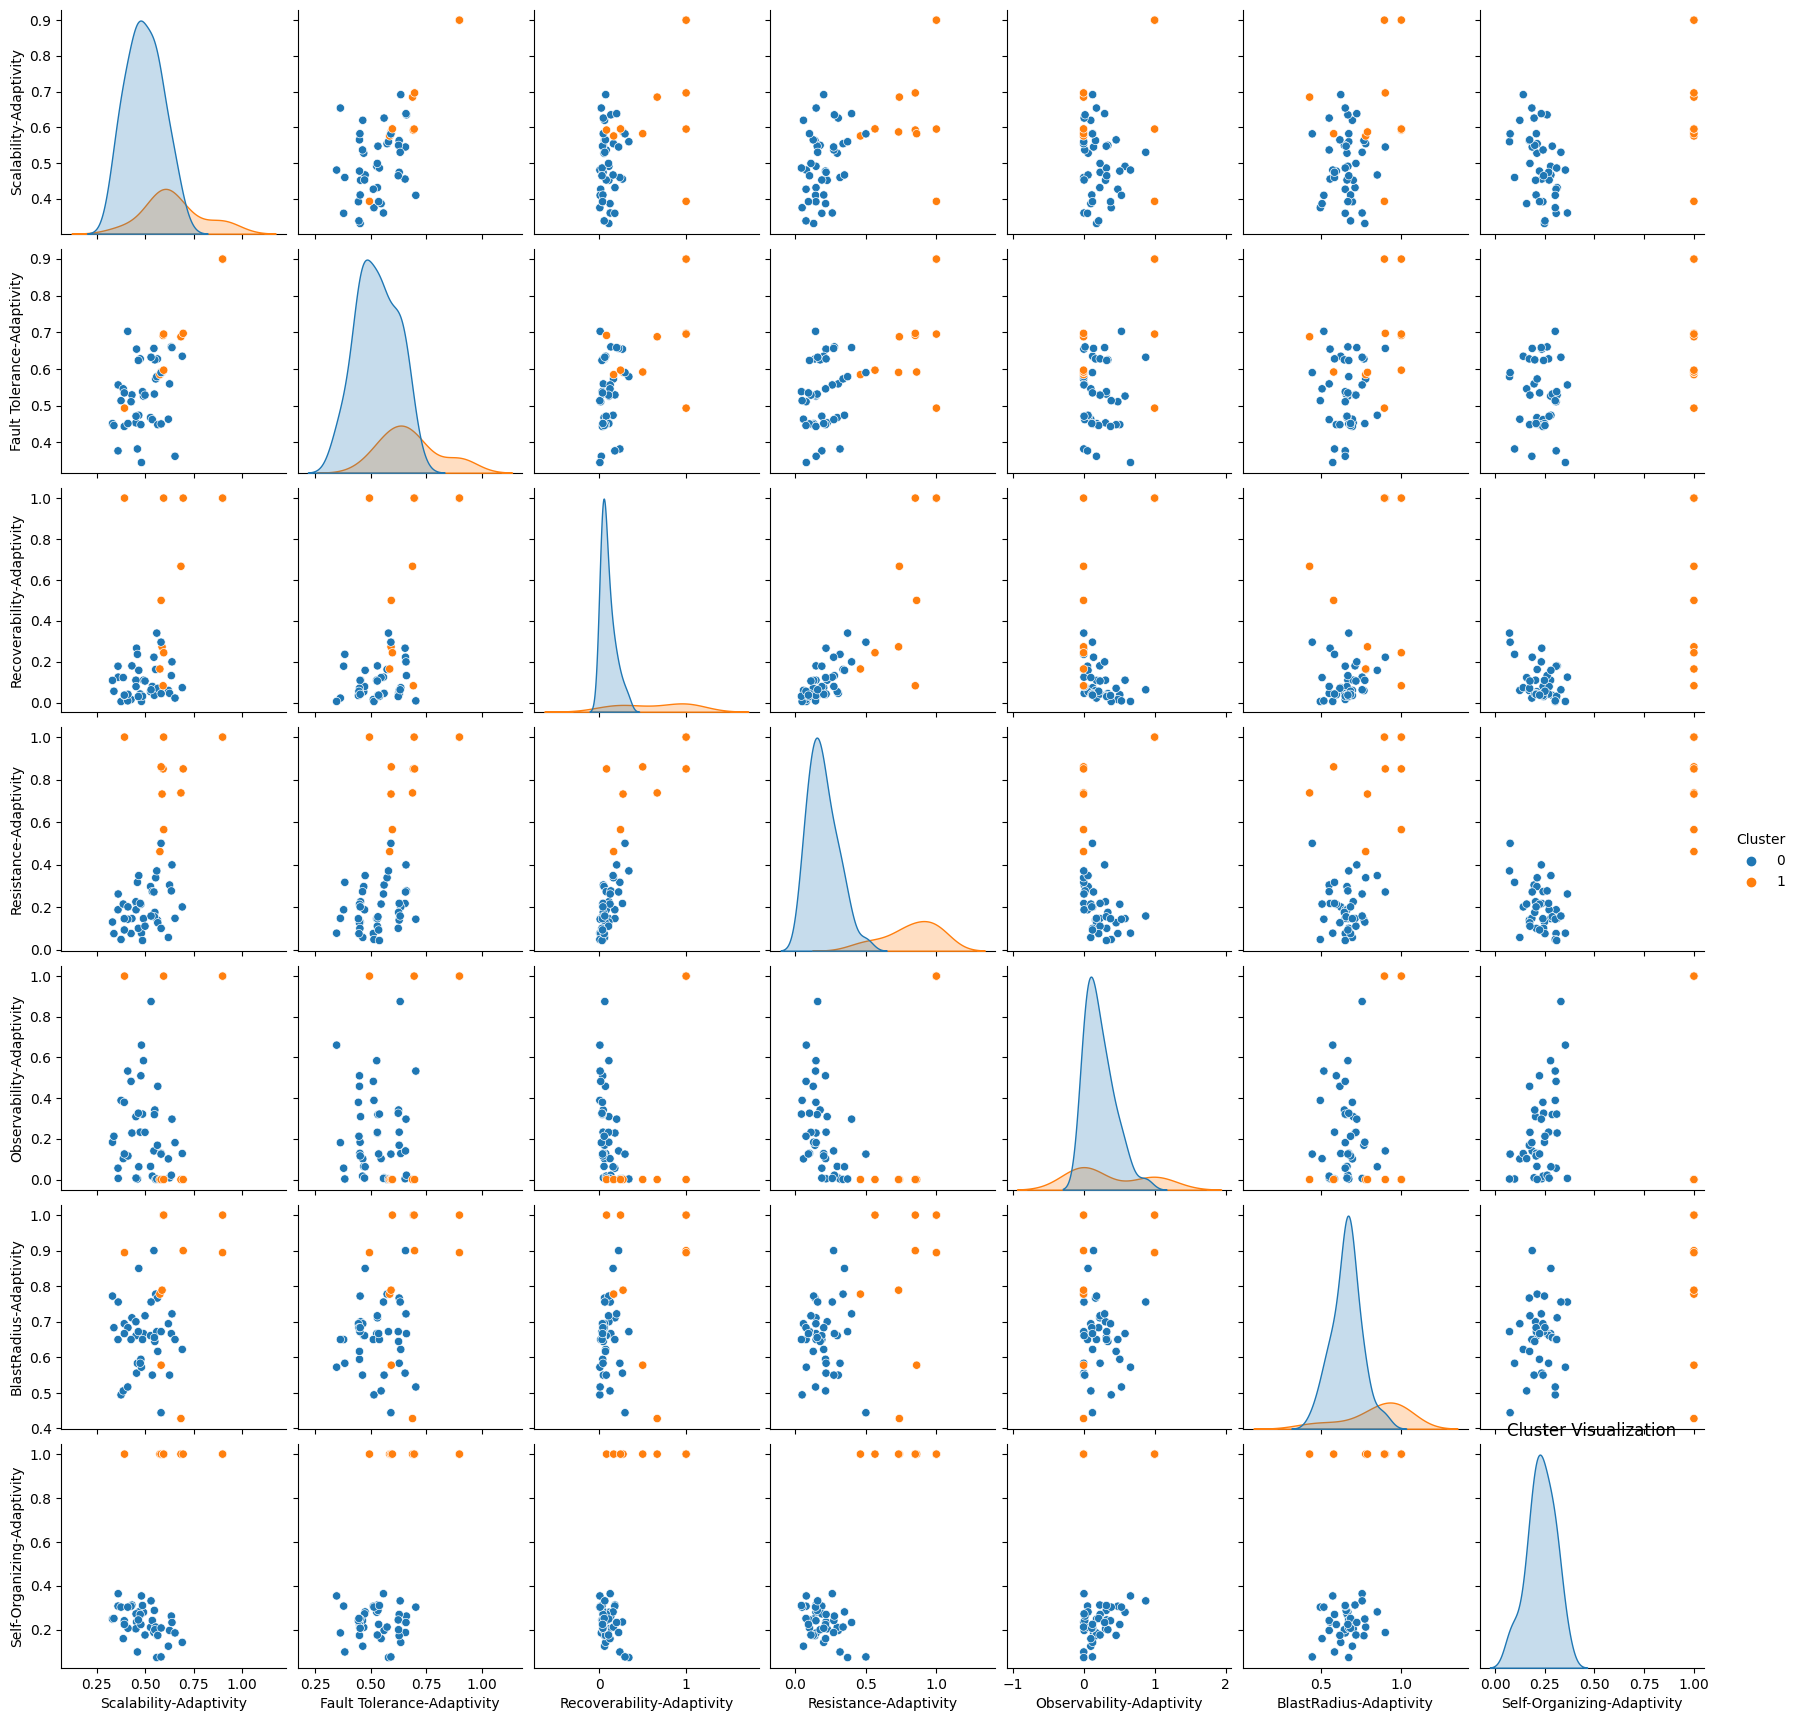

In [96]:
# Assuming you have a DataFrame called 'cpu_assessment' with a 'Cluster' column

dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity", 'Cluster']

# Creating a pair plot with color-coded clusters
sns.pairplot(experiment_summary_clusterd[dimensions], hue='Cluster')
plt.title('Cluster Visualization')
plt.show()

In [97]:
cpu_assessment

,Experimenttype,Group,System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity,Antifragility Score,Cluster
0,cpu,0,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.49105,0.52625,0.110100,0.14645,0.584100,0.66680,0.279500,0.400607,1
18,cpu,18,0,2023-07-18 01:43:46,2023-07-18 02:45:03,0.56295,0.62745,0.059350,0.13940,0.168500,0.76680,0.172500,0.356707,0
19,cpu,19,0,2023-07-18 02:46:39,2023-07-18 03:47:57,0.33110,0.45135,0.109200,0.13025,0.183450,0.77235,0.248556,0.318037,0
20,cpu,20,0,2023-07-18 03:49:23,2023-07-18 04:50:42,0.65385,0.36230,0.022750,0.14770,0.181250,0.65015,0.185250,0.314750,0
21,cpu,21,0,2023-07-18 04:52:09,2023-07-18 05:53:28,0.54965,0.62485,0.044750,0.17585,0.341850,0.64460,0.199889,0.368777,1
22,cpu,22,0,2023-07-18 06:43:46,2023-07-18 07:45:06,0.47760,0.44850,0.039000,0.21395,0.510050,0.59455,0.223500,0.358164,1
23,cpu,23,0,2023-07-18 07:46:35,2023-07-18 08:47:56,0.54725,0.53175,0.036300,0.15510,0.319200,0.65570,0.287813,0.361873,1
24,cpu,24,0,2023-07-18 08:49:31,2023-07-18 09:50:49,0.56490,0.44840,0.070389,0.12700,0.458278,0.61675,0.174125,0.351406,1
25,cpu,25,0,2023-07-18 21:43:46,2023-07-18 22:45:05,0.58215,0.45040,0.044600,0.10040,0.128800,0.67235,0.207786,0.312355,0
26,cpu,26,0,2023-07-18 22:46:34,2023-07-18 23:47:53,0.48050,0.34535,0.006350,0.07790,0.660650,0.57235,0.353800,0.356700,1


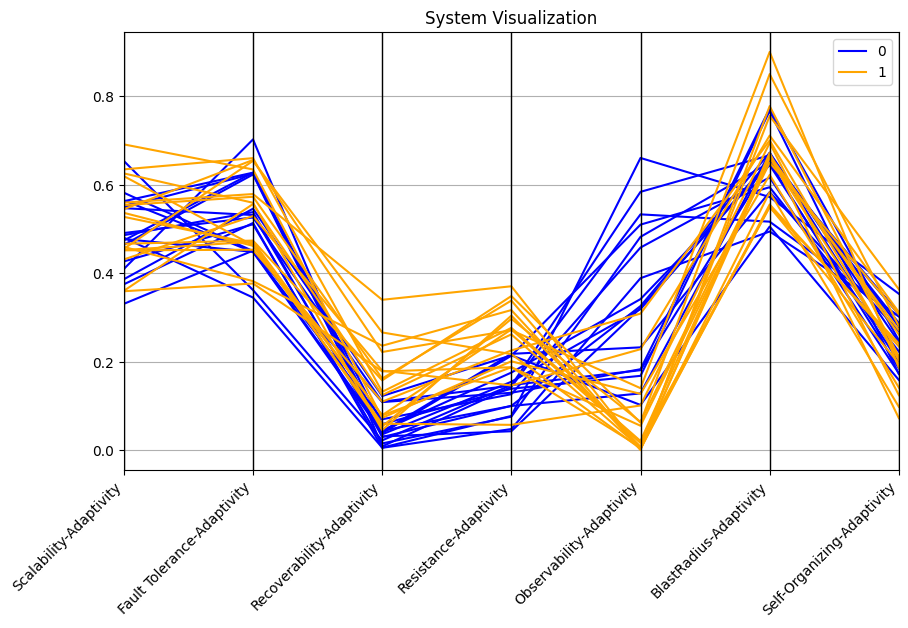

In [98]:
# Selecting the dimensions for the parallel coordinates plot
dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity"]

# Create the parallel coordinates plot with custom colors
plt.figure(figsize=(10, 6))
lines = parallel_coordinates(cpu_assessment[dimensions + ['System']], 'System', color=['blue','orange'])

# Adjust x-tick labels
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.15)

# Show the plot
plt.title('System Visualization')
plt.legend(loc='upper right')
plt.show()

In [99]:
cpu_assessment

,Experimenttype,Group,System,Start_time,End_time,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity,Antifragility Score,Cluster
0,cpu,0,0,2023-07-15 23:03:45,2023-07-16 00:05:03,0.49105,0.52625,0.110100,0.14645,0.584100,0.66680,0.279500,0.400607,1
18,cpu,18,0,2023-07-18 01:43:46,2023-07-18 02:45:03,0.56295,0.62745,0.059350,0.13940,0.168500,0.76680,0.172500,0.356707,0
19,cpu,19,0,2023-07-18 02:46:39,2023-07-18 03:47:57,0.33110,0.45135,0.109200,0.13025,0.183450,0.77235,0.248556,0.318037,0
20,cpu,20,0,2023-07-18 03:49:23,2023-07-18 04:50:42,0.65385,0.36230,0.022750,0.14770,0.181250,0.65015,0.185250,0.314750,0
21,cpu,21,0,2023-07-18 04:52:09,2023-07-18 05:53:28,0.54965,0.62485,0.044750,0.17585,0.341850,0.64460,0.199889,0.368777,1
22,cpu,22,0,2023-07-18 06:43:46,2023-07-18 07:45:06,0.47760,0.44850,0.039000,0.21395,0.510050,0.59455,0.223500,0.358164,1
23,cpu,23,0,2023-07-18 07:46:35,2023-07-18 08:47:56,0.54725,0.53175,0.036300,0.15510,0.319200,0.65570,0.287813,0.361873,1
24,cpu,24,0,2023-07-18 08:49:31,2023-07-18 09:50:49,0.56490,0.44840,0.070389,0.12700,0.458278,0.61675,0.174125,0.351406,1
25,cpu,25,0,2023-07-18 21:43:46,2023-07-18 22:45:05,0.58215,0.45040,0.044600,0.10040,0.128800,0.67235,0.207786,0.312355,0
26,cpu,26,0,2023-07-18 22:46:34,2023-07-18 23:47:53,0.48050,0.34535,0.006350,0.07790,0.660650,0.57235,0.353800,0.356700,1


## Show importance of dimension in predicting Weak or Strong System

In [100]:
# Extract the features and target variable
features = cpu_assessment[dimensions]
target = cpu_assessment['System']

# Create a Random Forest Regressor model
model = RandomForestRegressor()

# Fit the model to your data
model.fit(features, target)

# Get the feature importances
feature_importances = model.feature_importances_

# Print the feature importances
for i, importance in enumerate(feature_importances):
    print(f"Dimension {dimensions[i]}: {importance}")

Dimension Scalability-Adaptivity: 0.016089319537626354
Dimension Fault Tolerance-Adaptivity: 0.0040555520241828385
Dimension Recoverability-Adaptivity: 0.28401377869573197
Dimension Resistance-Adaptivity: 0.18542154029568383
Dimension Observability-Adaptivity: 0.4515395433540513
Dimension BlastRadius-Adaptivity: 0.04017034249873246
Dimension Self-Organizing-Adaptivity: 0.018709923593991058


## Evaluation: Reliability

In [101]:
system_1 = experiments_summary[experiments_summary['System']==0]
system_2 = experiments_summary[experiments_summary['System']==1]
len(system_1)

30

In [102]:
dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity"]

system_1_scores = system_1[dimensions]
print(len(system_1_scores))


# Calculate metrics
std_devs = system_1_scores.std()
variances = system_1_scores.var()
coefficient_of_variation = (std_devs / system_1_scores.mean()) * 100
ranges = system_1_scores.max() - system_1_scores.min()
mean_absolute_deviations = system_1_scores.sub(system_1_scores.mean()).abs().mean()

# Create the dataframe
reliability_eval_metrics = {
    'Metric': ['Standard Deviation', 'Variance', 'Coefficient of Variation', 'Range', 'Mean Absolute Deviation'],
    'Scalability-Adaptivity': [std_devs[0], variances[0], coefficient_of_variation[0], ranges[0], mean_absolute_deviations[0]],
    'Fault Tolerance-Adaptivity': [std_devs[1], variances[1], coefficient_of_variation[1], ranges[1], mean_absolute_deviations[1]],
    'Recoverability-Adaptivity': [std_devs[2], variances[2], coefficient_of_variation[2], ranges[2], mean_absolute_deviations[2]],
    'Resistance-Adaptivity': [std_devs[3], variances[3], coefficient_of_variation[3], ranges[3], mean_absolute_deviations[3]],
    'Observability-Adaptivity': [std_devs[4], variances[4], coefficient_of_variation[4], ranges[4], mean_absolute_deviations[4]],
    'BlastRadius-Adaptivity': [std_devs[5], variances[5], coefficient_of_variation[5], ranges[5], mean_absolute_deviations[5]],
    'Self-Organizing-Adaptivity': [std_devs[6], variances[6], coefficient_of_variation[6], ranges[6], mean_absolute_deviations[6]]
}
reliability_eval_metrics = pd.DataFrame(reliability_eval_metrics)

30


In [103]:
reliability_eval_metrics.style

,Metric,Scalability-Adaptivity,Fault Tolerance-Adaptivity,Recoverability-Adaptivity,Resistance-Adaptivity,Observability-Adaptivity,BlastRadius-Adaptivity,Self-Organizing-Adaptivity
0,Standard Deviation,0.094460,0.097023,0.131534,0.281074,0.218975,0.147835,0.065017
1,Variance,0.008923,0.009414,0.017301,0.079002,0.047950,0.021855,0.004227
2,Coefficient of Variation,19.088716,17.905992,141.929685,103.337786,76.736866,21.707727,27.212245
3,Range,0.353300,0.357200,0.660767,0.956650,0.875000,0.572050,0.277800
4,Mean Absolute Deviation,0.079130,0.079041,0.077048,0.214039,0.176534,0.104872,0.051952


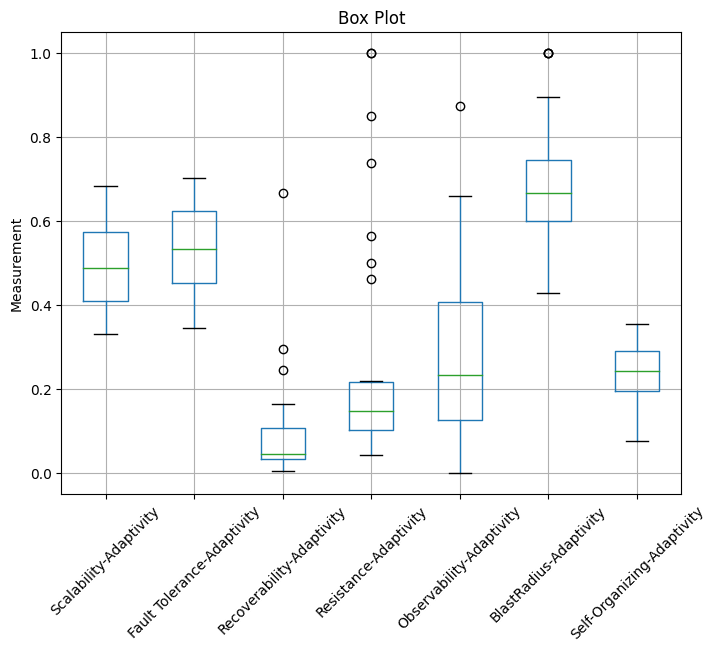

In [104]:

# Plotting Box Plot
fig, ax = plt.subplots(figsize=(8, 6))
system_1_scores.boxplot(ax=ax)
ax.set_ylabel('Measurement')
ax.set_title('Box Plot')
plt.xticks(rotation=45)
plt.show()

In [105]:
dimensions = ['Scalability-Adaptivity', 'Fault Tolerance-Adaptivity', 'Recoverability-Adaptivity',
              'Resistance-Adaptivity', 'Observability-Adaptivity', 'BlastRadius-Adaptivity', "Self-Organizing-Adaptivity"]

system_2_scores = system_2[dimensions]
print(len(system_2_scores))

# Calculate metrics
std_devs = system_2_scores.std()
variances = system_2_scores.var()
coefficient_of_variation = (std_devs / system_2_scores.mean()) * 100
ranges = system_2_scores.max() - system_2_scores.min()
mean_absolute_deviations = system_2_scores.sub(system_2_scores.mean()).abs().mean()

23


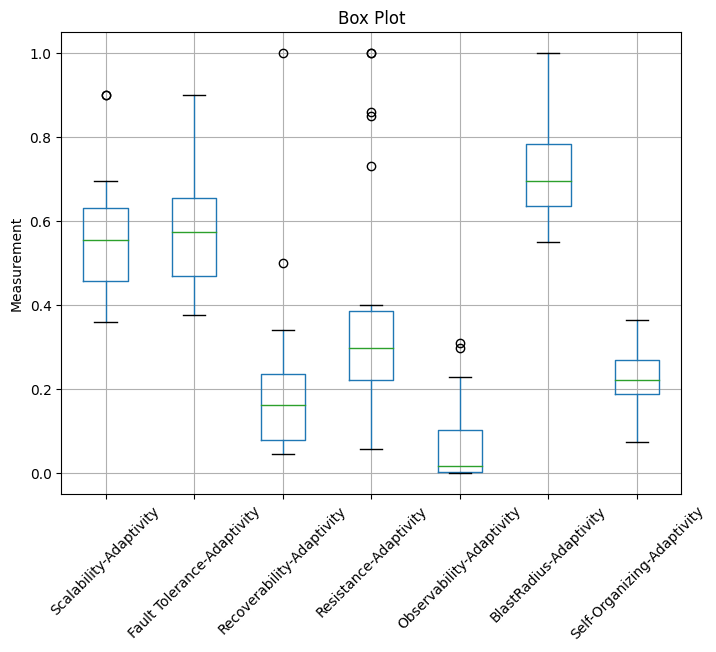

In [106]:

# Plotting Box Plot
fig, ax = plt.subplots(figsize=(8, 6))
system_2_scores.boxplot(ax=ax)
ax.set_ylabel('Measurement')
ax.set_title('Box Plot')
plt.xticks(rotation=45)
plt.show()

In [107]:
system_1_summary_score = pd.DataFrame()
system_1_summary_score['Antifragility-Score'] =system_1_scores.mean(axis=1)


In [108]:
# Calculate metrics
std_devs = system_1_summary_score.std()
variances = system_1_summary_score.var()
coefficient_of_variation = (std_devs / system_1_summary_score.mean()) * 100
ranges = system_1_summary_score.max() - system_1_summary_score.min()
mean_absolute_deviations = system_1_summary_score.sub(system_1_summary_score.mean()).abs().mean()

print(f"Std {std_devs}")
print(f"Var {variances}")
print(f"Coefficient of Variation {coefficient_of_variation}")
print(f"Range {ranges}")
print(f"Mean Absolute Deviations {mean_absolute_deviations}")

Std Antifragility-Score    0.1207
dtype: float64
Var Antifragility-Score    0.014569
dtype: float64
Coefficient of Variation Antifragility-Score    30.700622
dtype: float64
Range Antifragility-Score    0.531392
dtype: float64
Mean Absolute Deviations Antifragility-Score    0.083274
dtype: float64


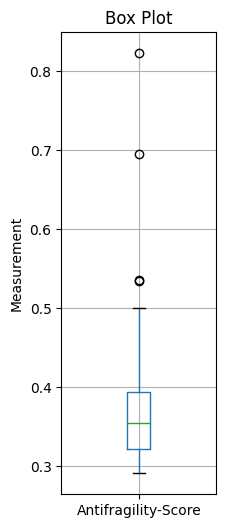

In [109]:
system_1_summary_score = pd.DataFrame(system_1_summary_score)
# Plotting Box Plot
fig, ax = plt.subplots(figsize=(2, 6))
system_1_summary_score.boxplot(ax=ax)
ax.set_ylabel('Measurement')
ax.set_title('Box Plot')
plt.xticks()
plt.show()